# Giriş
"Credit Card Fraud Detection" dosyası 2013 yılın eylül ayında avrupalı kredi kartı sahiplerinin hesap akışlarını içermektedir.
Veritabanındaki veriler 2 gün içerisinde yapılan 284.807 akışı içermektedir. Bu akışlardan 492 si dolandırıcılık/sahtekarlık amacı ile yapılan aktarımlardır. Dolandırıcılık aktarımları bütün veritabanının 0.172% sini oluşturmaktadır. 
Veriler sadece sayısal değerlerden oluşmaktadır. Bu sayısal veriler PCA (principal component analysis) ile elde edilmiştir. 
Gizlilik sebebi ile orjinal veriler ve verilerin arkaplan bilgisi verilmemiştir. 
V1, V2, V3 ... V28 PCA ile elde edilen verilerdir. Sadece Zaman ve miktar bilgisi PCA ile çevrilmemiştir. 
* V1, V2, V3 ... V28 -> PCA ile elde edilen veriler
* 'Time', 'Amount'   -> PCA ile çevrilmeden gösterilen veriler
    * 'Time'   -> En baştaki aktarım ile mevcut aktarım arasında geçen süre (saniye cinsinden)
    * 'Amount' -> Aktarım yapılan para miktarı
* 'Class'      -> Aktarımın dolancırılık olup olmadığını göstermektedir (1:Dolandırıcılık    0:Dolandırıcılık değil)

### İçerik
1. [Import and Check Data](#1)
2. [Outlier Cleaning](#2)
3. [Variable Analysis (EDA)](#3)
4. [Preprocessing](#4)
5. [Training](#5)

In [47]:
# gerekli kütüphaneler import ediliyor

import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np

import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import tensorflow as tf 
from tensorflow.keras import Sequential

from tensorflow.keras.layers import Dense,InputLayer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score

<a id="1"></a>
## 1. Import and Check Data

In [48]:
# Veri çalışma alanına dahil ediliyor
data = pd.read_csv("creditcard.csv") 

In [49]:
data = data.drop_duplicates() # Birebir aynı veri varsa siliniyor

In [50]:
# veri setindeki sütunların ne olduğunu listeliyor
data.columns 

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [51]:
# Verinin ilk 5 satırı gösteriliyor
data.head() 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [52]:
# Sütunlardaki verilerin türü ve sayısı gösteriliyor
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 283726 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    283726 non-null  float64
 1   V1      283726 non-null  float64
 2   V2      283726 non-null  float64
 3   V3      283726 non-null  float64
 4   V4      283726 non-null  float64
 5   V5      283726 non-null  float64
 6   V6      283726 non-null  float64
 7   V7      283726 non-null  float64
 8   V8      283726 non-null  float64
 9   V9      283726 non-null  float64
 10  V10     283726 non-null  float64
 11  V11     283726 non-null  float64
 12  V12     283726 non-null  float64
 13  V13     283726 non-null  float64
 14  V14     283726 non-null  float64
 15  V15     283726 non-null  float64
 16  V16     283726 non-null  float64
 17  V17     283726 non-null  float64
 18  V18     283726 non-null  float64
 19  V19     283726 non-null  float64
 20  V20     283726 non-null  float64
 21  V21     283726 

Verinin sadece sayısal değerlerden oluştuğu görünüyor.

In [53]:
data.isnull().sum() # boş verilerin varlığı kontrol ediliyor

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

<a id="2"></a>
## 2. Outlier Cleaning
Bu kısımda veri analizini yapabilmek için öncelikle outlier tespiti yapıp gerekli olanları sileceğim.

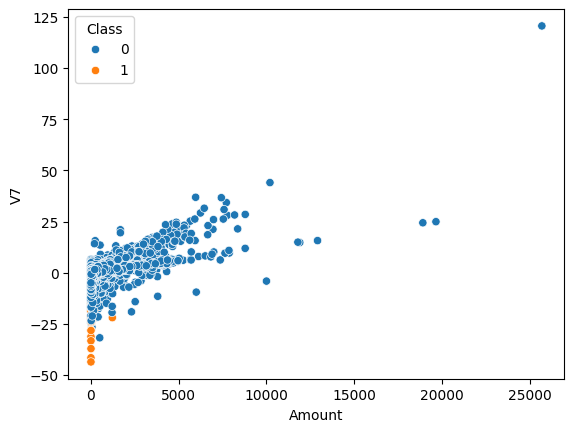

In [54]:
sns.scatterplot(x="Amount",y="V7",hue="Class",data=data) # Scatter plot ile Amount/V7 grafiğine bakıyoruz
plt.show()

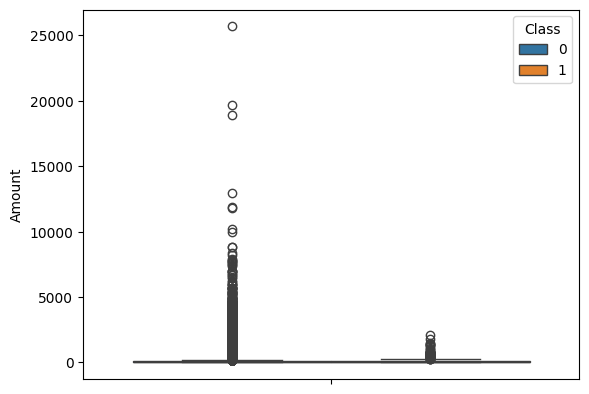

In [55]:
sns.boxplot(y="Amount",hue="Class",data=data) # Boxplot ile Class'a göre amount dağılımlarına bakıyoruz 
plt.show()

Bu grafiklere baktığımızda Amount değişkeninde çok fazla outlier olduğu görülmektedir. Dolandırıcılıkla ilgili olan aktarımların miktarının çok yüksek olmadığı çok kolay şekilde görünmektedir. Bu durumda dolandırıcılıkla ilgili çok fazla veri kaybı olmadan 4000 üstünü silebiliriz.

In [56]:
# Amount değeri 4000 üstünde olan veriler siliniyor
data = data.drop(data[data["Amount"] > 4000].index, axis=0).reset_index(drop=True)


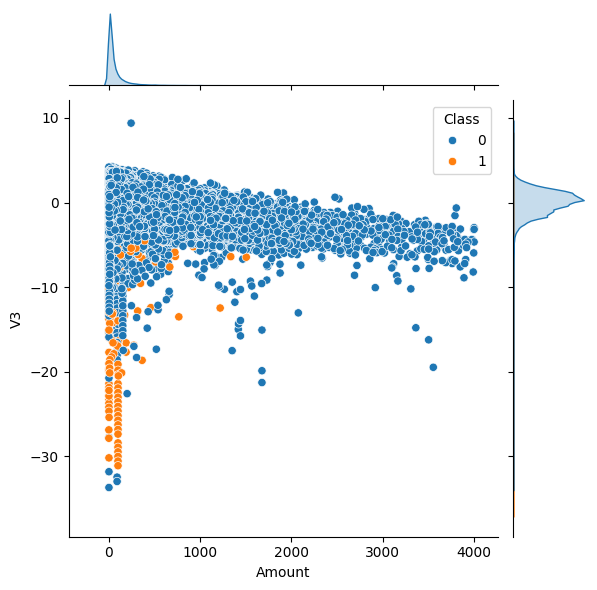

In [57]:
# Amount ve V3 değerlerine göre dağılım grafiği çizdiriliyor 
sns.jointplot(x="Amount",y="V3",hue="Class",data=data)
plt.show()

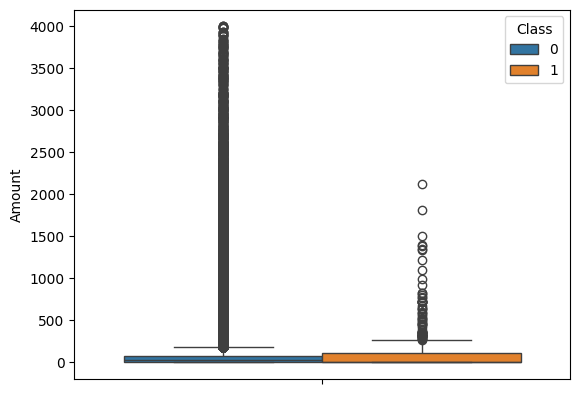

In [58]:
# Amount değerlerinin Class'a göre dağılım grafiği çizdiriliyor
sns.boxplot(y="Amount",hue="Class",data=data) 
plt.show()

Bu iki grafiği incelediğimizde 500 üstünü silmenin daha iyi bir temizlik yapacağını görmekteyim.

In [59]:
# Amount değeri 500 üzeri olan 
data = data.drop(data[data["Amount"] > 500].index, axis=0).reset_index(drop=True)


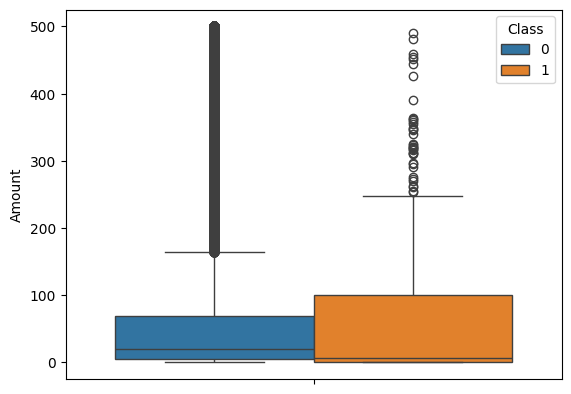

In [60]:
sns.boxplot(y="Amount",hue="Class",data=data) # Amount ve Class sınıfına göre dağılım grafiği çizdiriliyor 
plt.show()

Şimdilik bu şekilde analize devam edeceğim. Daha fazla temizlediğimiz zaman outliner sayısında değişim olmuyor. Geriye kalan kısımda da outlinerlar bulunuyor. Gerekli düzenlemelere analiz kısmından sonra devam edeceğim.

<a id="3"></a>
## 3. Variable Analysis (EDA)
Bu kısımda veriyi analiz ederek değişkenler arasındaki bağlantıyı inceleyeceğim.

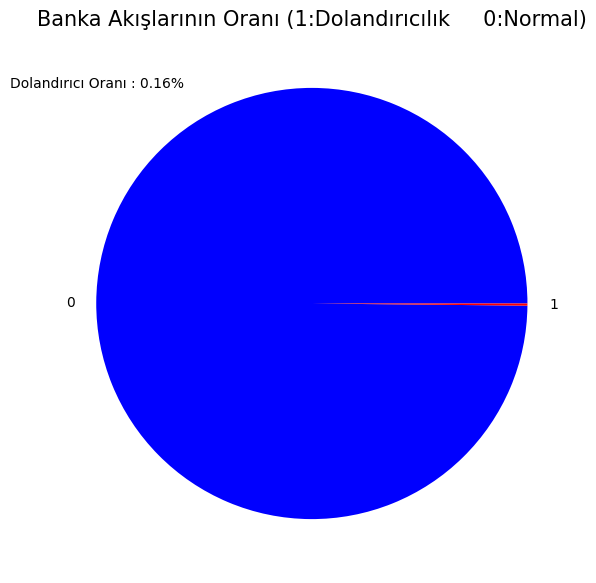

In [61]:
labels = data.Class.value_counts().index 
colors = ["blue","red"]
explode = [0,0]
sizes = data.Class.value_counts().values

ratio = sizes[1] / (sizes[0] + sizes[1]) * 100

plt.figure(figsize=(7,7))
plt.pie(sizes,explode=explode,labels=labels,colors=colors)
plt.title("Banka Akışlarının Oranı (1:Dolandırıcılık     0:Normal)",fontsize=15,color="black")
plt.text(x = -1.4, y=1, s=f"Dolandırıcı Oranı : {ratio:.2f}%")
plt.show()

Bu grafikte dolandırıcılıkla ilgili aktarımların tüm veritabanının yüzde 0.17'lik çok küçük bir kısmını oluşturduğu görülmektedir. Bu durumu eğitim kısmından önce tekrar gözden geçireceğim.

<Axes: >

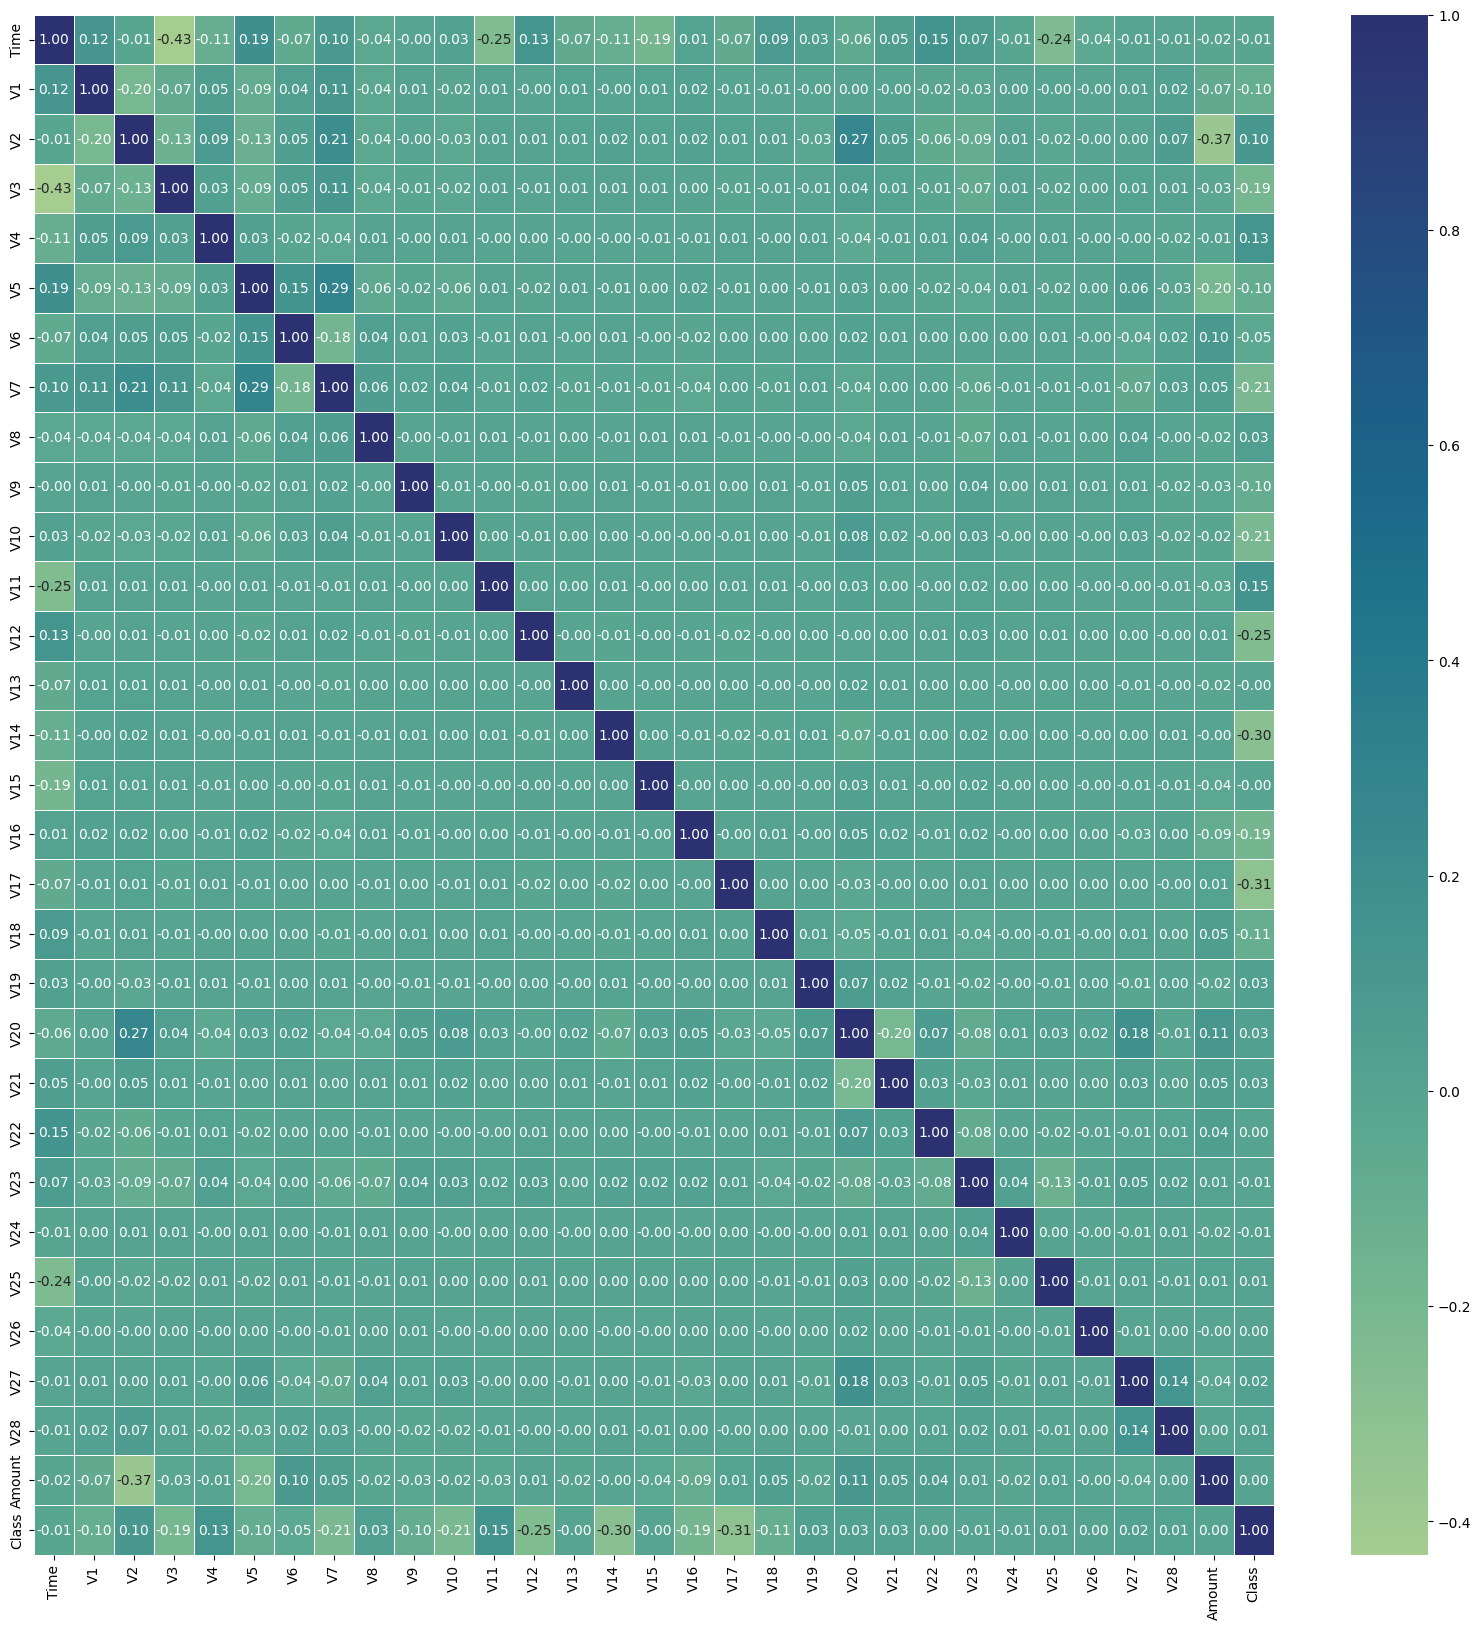

In [62]:
# 20x20 boyutunda figür oluşturuluyor 
plt.figure(figsize=(20,20))
# farklı değişkenlerin korelasyon grafiği çizdiriliyor
sns.heatmap(data.corr(),fmt=".2f",annot=True,linewidths=0.5,cmap="crest")

Bu grafikte farklı değişkenlerin birbirleri ile olan korelasyonları görünmektedir. Çoğu verinin arasında güçlü pozitif veya negatif bağlantı görülmemektedir. Çok olmasa da birbirleri ile ilişki içinde olarak görünen veriler şunlardır : 
* Amount - V2
* Time   - V3 

Şimdi, elimdeki veriyi normal olan ve dolandırıcı olan aktarımlar olarak ikiye böleceğim. Dolandırıcı olmayan verilerdeki dengesizliği undersampling ile çözmeye çalışacağım. Daha sonra iki veriyi tekrar birleştireceğim.

In [63]:
# datadaki Class bilgisi 0 olan veriler ayrılıyor
d_normal = data[data["Class"] == 0]

# datadaki Class bilgisi 1 olan veriler ayrılıyor
d_fraud = data[data["Class"] == 1]

Normal olan aktarımların sayısı 283253 olarak görünüyor. Bu aktarımlardan outliner olanları silip rastgele 473 veri alacağım. Bu sayede veri setindeki dengesizliğin düzeleceğini düşünmekteyim.

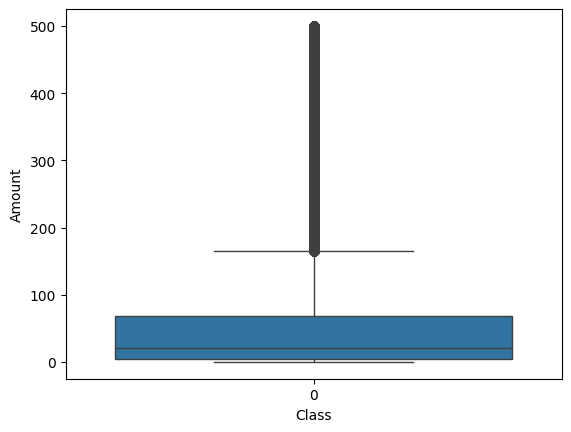

In [64]:
# Class ve Amount değişkenine göre dağılım grafiği çizdiriliyor 
sns.boxplot(x="Class",y="Amount",data=d_normal) 
plt.show()

In [65]:
def detect_outliers(df, feature):

    """
    Belirlenen featuredaki outlierları tespit edip indislerini return eder

    Args:
        df : Veritabanı
        b  : Featurların bulunduğu liste

    Returns:
        list : outlier indislerini bulunduran liste
    """

    #  outlier indislerinin kaydedileceği liste tanımlanıyor
    outlier_indices = [] 

    Q1 = df[feature].quantile(0.25) # lowerquartile hesaplanıyor 
    Q3 = df[feature].quantile(0.75) # Upperquartile hesaplanıyor 
    IQR = Q3 - Q1                   # IQR değeri hesaplanıyor
    outlier_step = 1.5 * IQR        # outlier hesaplamak için mesafe hesaplanıyor 

    # outlierları bulmak için veriye filtre uygulanıyor ve kaydediliyor 
    outlier_list_col = df[(df[feature] < (Q1 - outlier_step)) | (df[feature] > (Q3 + outlier_step))]

    # Filtrelenen veriler liste haline çevriliyor
    outlier_indices.extend(outlier_list_col.index.tolist()) 

    return sorted(set(outlier_indices))  # elde edilen liste return ediliyor 

In [66]:
# Outlier listesindeki indis sayısı 1 den büyük olana kadar 
while(len(detect_outliers(d_normal,"Amount"))>1):
    # outlierlar tespit edilip siliniyor 
    d_normal = d_normal.drop(detect_outliers(d_normal,"Amount"),axis = 0).reset_index(drop = True)

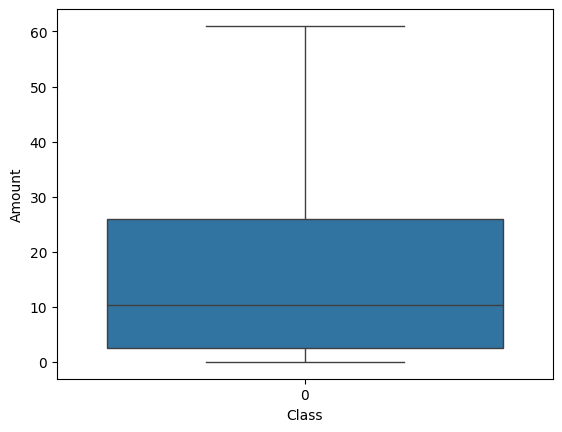

In [67]:
# Class ve Amount değişkenlerine göre dağılım grafiği çizdiriliyor 
sns.boxplot(x="Class",y="Amount",data=d_normal)
plt.show()

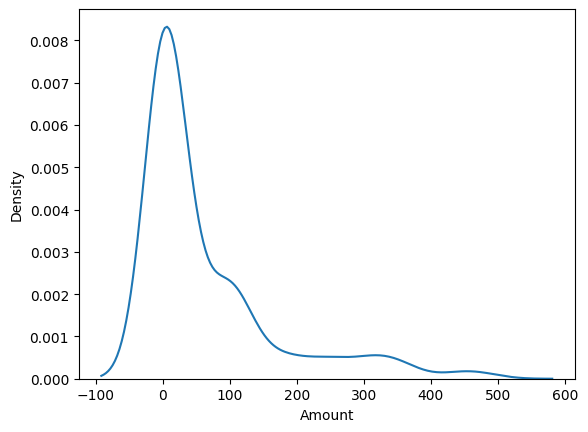

In [68]:
# Amount değişkeninin dağılım grafiği çizdiriliyor
sns.kdeplot(data=d_fraud, x="Amount")
plt.show()

In [69]:
d_fraud.shape 

(439, 31)

In [70]:
d_normal.shape

(200463, 31)

In [71]:
d_normal = d_normal.sample(n=439)
d_normal.shape

(439, 31)

In [72]:
dataN=pd.concat([d_normal,d_fraud],axis=0)

In [73]:
dataN.shape

(878, 31)

In [74]:
dataN.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
67760,67525.0,1.027843,-0.296708,1.238361,1.068914,-0.843689,0.678493,-0.959778,0.468581,0.587343,...,0.316273,0.831956,-0.106282,-0.320997,0.248515,-0.205859,0.072816,0.030244,42.97,0
177671,156842.0,-0.625806,0.681357,0.898006,-0.228707,1.286742,-0.270993,0.779938,-0.101897,-0.676746,...,-0.312283,-0.918249,-0.354351,-1.036241,0.497390,0.568713,-0.018583,0.048464,0.89,0
126363,124340.0,2.038683,-0.079572,-1.200947,0.193881,0.190902,-0.562181,0.097662,-0.169019,0.221050,...,-0.251229,-0.589735,0.278151,-0.450420,-0.271033,0.206405,-0.068197,-0.073460,1.98,0
159690,145982.0,2.032957,-0.153217,-1.193110,0.220562,0.063518,-0.627312,0.028434,-0.114303,0.374080,...,-0.258584,-0.662143,0.299375,-0.408399,-0.315711,0.205529,-0.074920,-0.074985,1.98,0
48435,54481.0,-0.605873,0.825315,-0.211498,-1.232447,2.885175,3.253130,0.453630,0.798183,-0.592586,...,0.093388,0.049223,-0.248134,0.987868,0.256024,-0.539061,-0.021300,0.120713,4.99,0


Yapılan işlemler sayesinde normal ve dolandırıcı akışlar eşit oranda alınmıştır. Aynı zamanda outlinerlardan kurtulunmuştur. Verilerin oranı aşağıdaki pasta dilimi grafiğinde görünmektedir.

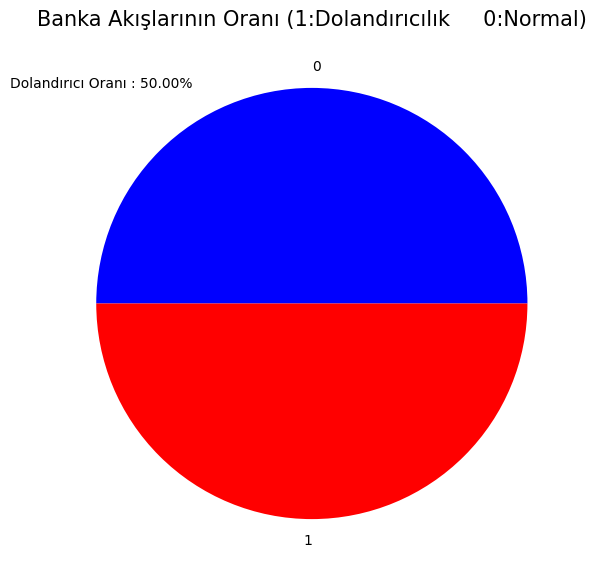

In [75]:
labels = dataN.Class.value_counts().index
colors = ["blue","red"]
explode = [0,0]
sizes = dataN.Class.value_counts().values

ratio = sizes[1] / (sizes[0] + sizes[1]) * 100

plt.figure(figsize=(7,7))
plt.pie(sizes,explode=explode,labels=labels,colors=colors)
plt.title("Banka Akışlarının Oranı (1:Dolandırıcılık     0:Normal)",fontsize=15,color="black")
plt.text(x = -1.4, y=1, s=f"Dolandırıcı Oranı : {ratio:.2f}%")
plt.show()

<Axes: >

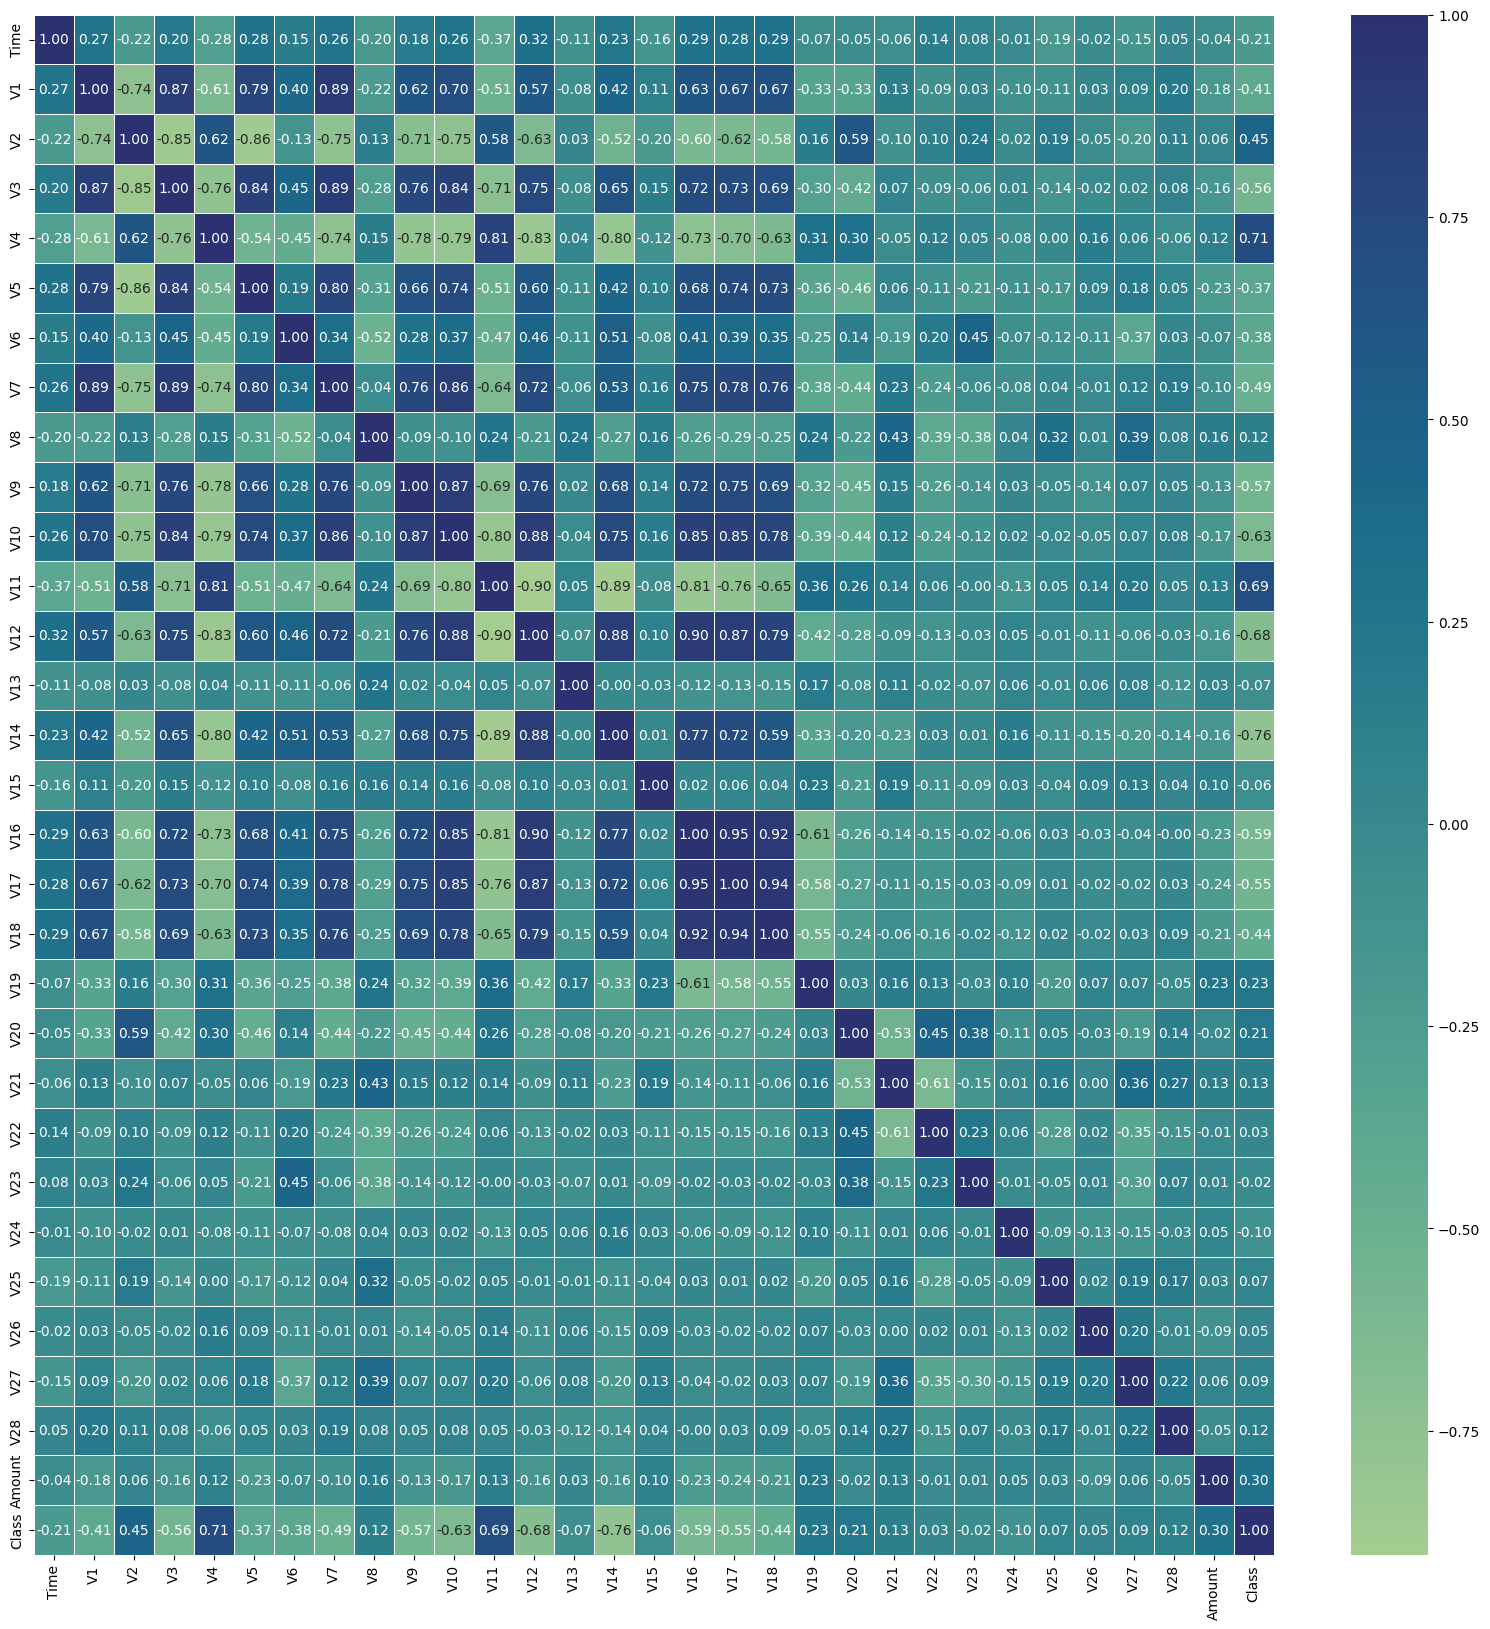

In [76]:
plt.figure(figsize=(20,20))
sns.heatmap(dataN.corr(),fmt=".2f",annot=True,linewidths=0.5,cmap="crest")

Veriyi temizleyip eşitledikten sonra farklı değişkenler arasındaki korelasyon daha belirgin oldu. Görüldüğü üzere sol üstteki ve sağ üstteki bazı değişkenler arasında güçlü korelasyon bulunmaktadır. Yüzde 96'ya kadar varan korelasyon değerleri bulunmaktadır.
Direkt olarak class değişkeni ile korelasyon gösteren değişkenler de bulunmaktadır.

In [77]:
dataN["Class_Label"] = ["Dolandırıcı" if i==1 else "Normal" for i in dataN["Class"]]

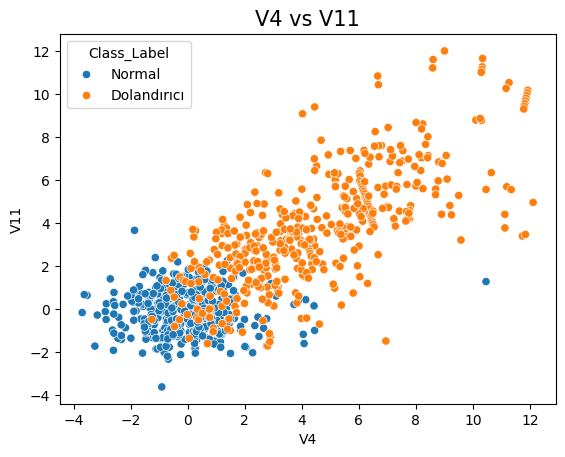

In [78]:
sns.scatterplot(x="V4",y="V11",hue="Class_Label",data=dataN)
plt.title("V4 vs V11",fontsize=15,color="black")
plt.show()

Yukarıda class değişkeni ile korelasyon gösteren V4 ve V11 adlı değişkenlerin scatter grafiği görülmektedir. Bu grafikte iki küme net şekilde görünmektedir. Fakat net bir ayrım yapılamamaktadır. Çünkü iki küme belli bir bölgede kesişmektedir. 
Diğer değişkenlerin grafiklerini de inceleyelim.

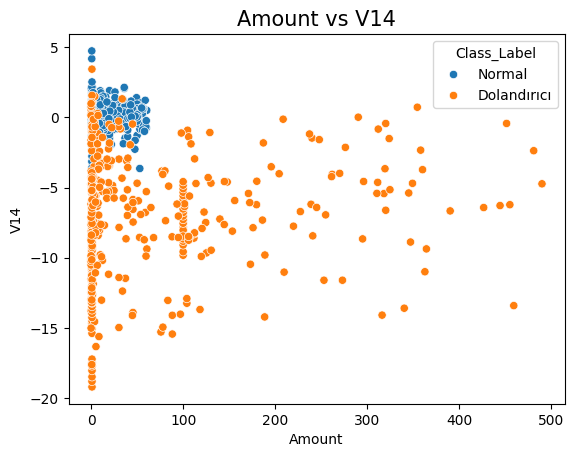

In [79]:
sns.scatterplot(x="Amount",y="V14",hue="Class_Label",data=dataN)
plt.title("Amount vs V14",fontsize=15,color="black")
plt.show()

Bu grafikte Amount ve V14 değişkeninin dağılımı görülmektedir. Dağılıma baktığımızda 

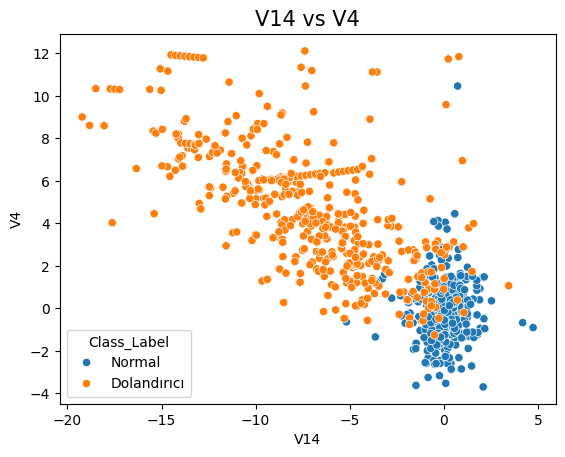

In [80]:
sns.scatterplot(x="V14",y="V4",hue="Class_Label",data=dataN)
plt.title("V14 vs V4",fontsize=15,color="black")
plt.show()

Bu grafikte de iki küme net şekilde görünmekte fakat yine ayrım yapılamamaktadır. Bu sayede sadece iki değişkenle ayrım yapamayacağımızı anladım. Farklı değişkenleri aynı anda analiz ederek ayrıma ulaşabileceğimizi düşünüyorum.

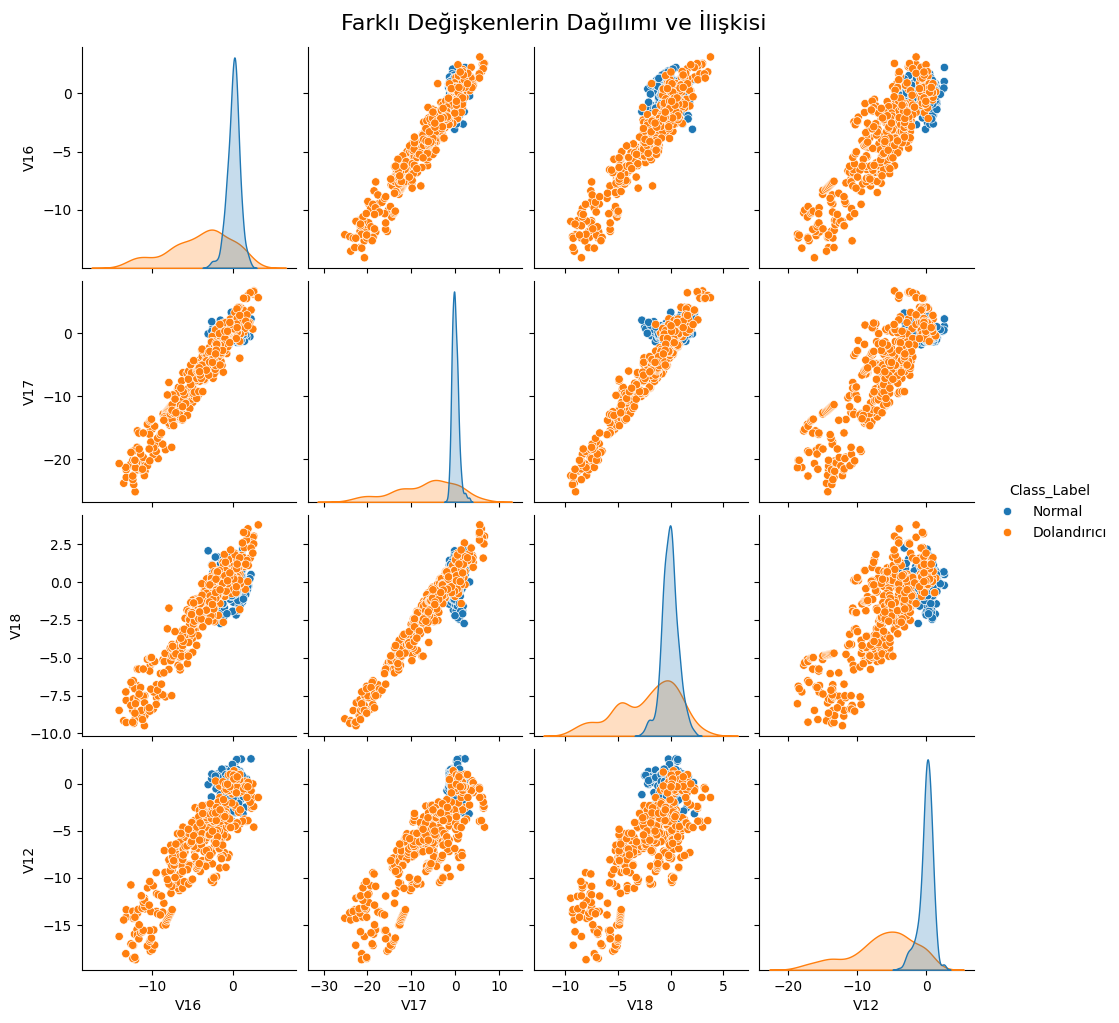

In [81]:
sns.pairplot(dataN.loc[:,["V16", "V17", "V18","V12","Class_Label"]], hue="Class_Label")
plt.suptitle("Farklı Değişkenlerin Dağılımı ve İlişkisi", fontsize=16, y=1.02)
plt.show()

Yukarıdaki grafiklerde kümelenmeler görünüyor. Dolandırıcı amaçlı aktarımlar geniş bir dağılım göstermiştir. Normal olan aktarımlara bakıldığında daha dar bir alana yayıldıkları görünmektedir. Özellikle V17 değişkeninde yayılım farkı çok fazla görünmektedir.

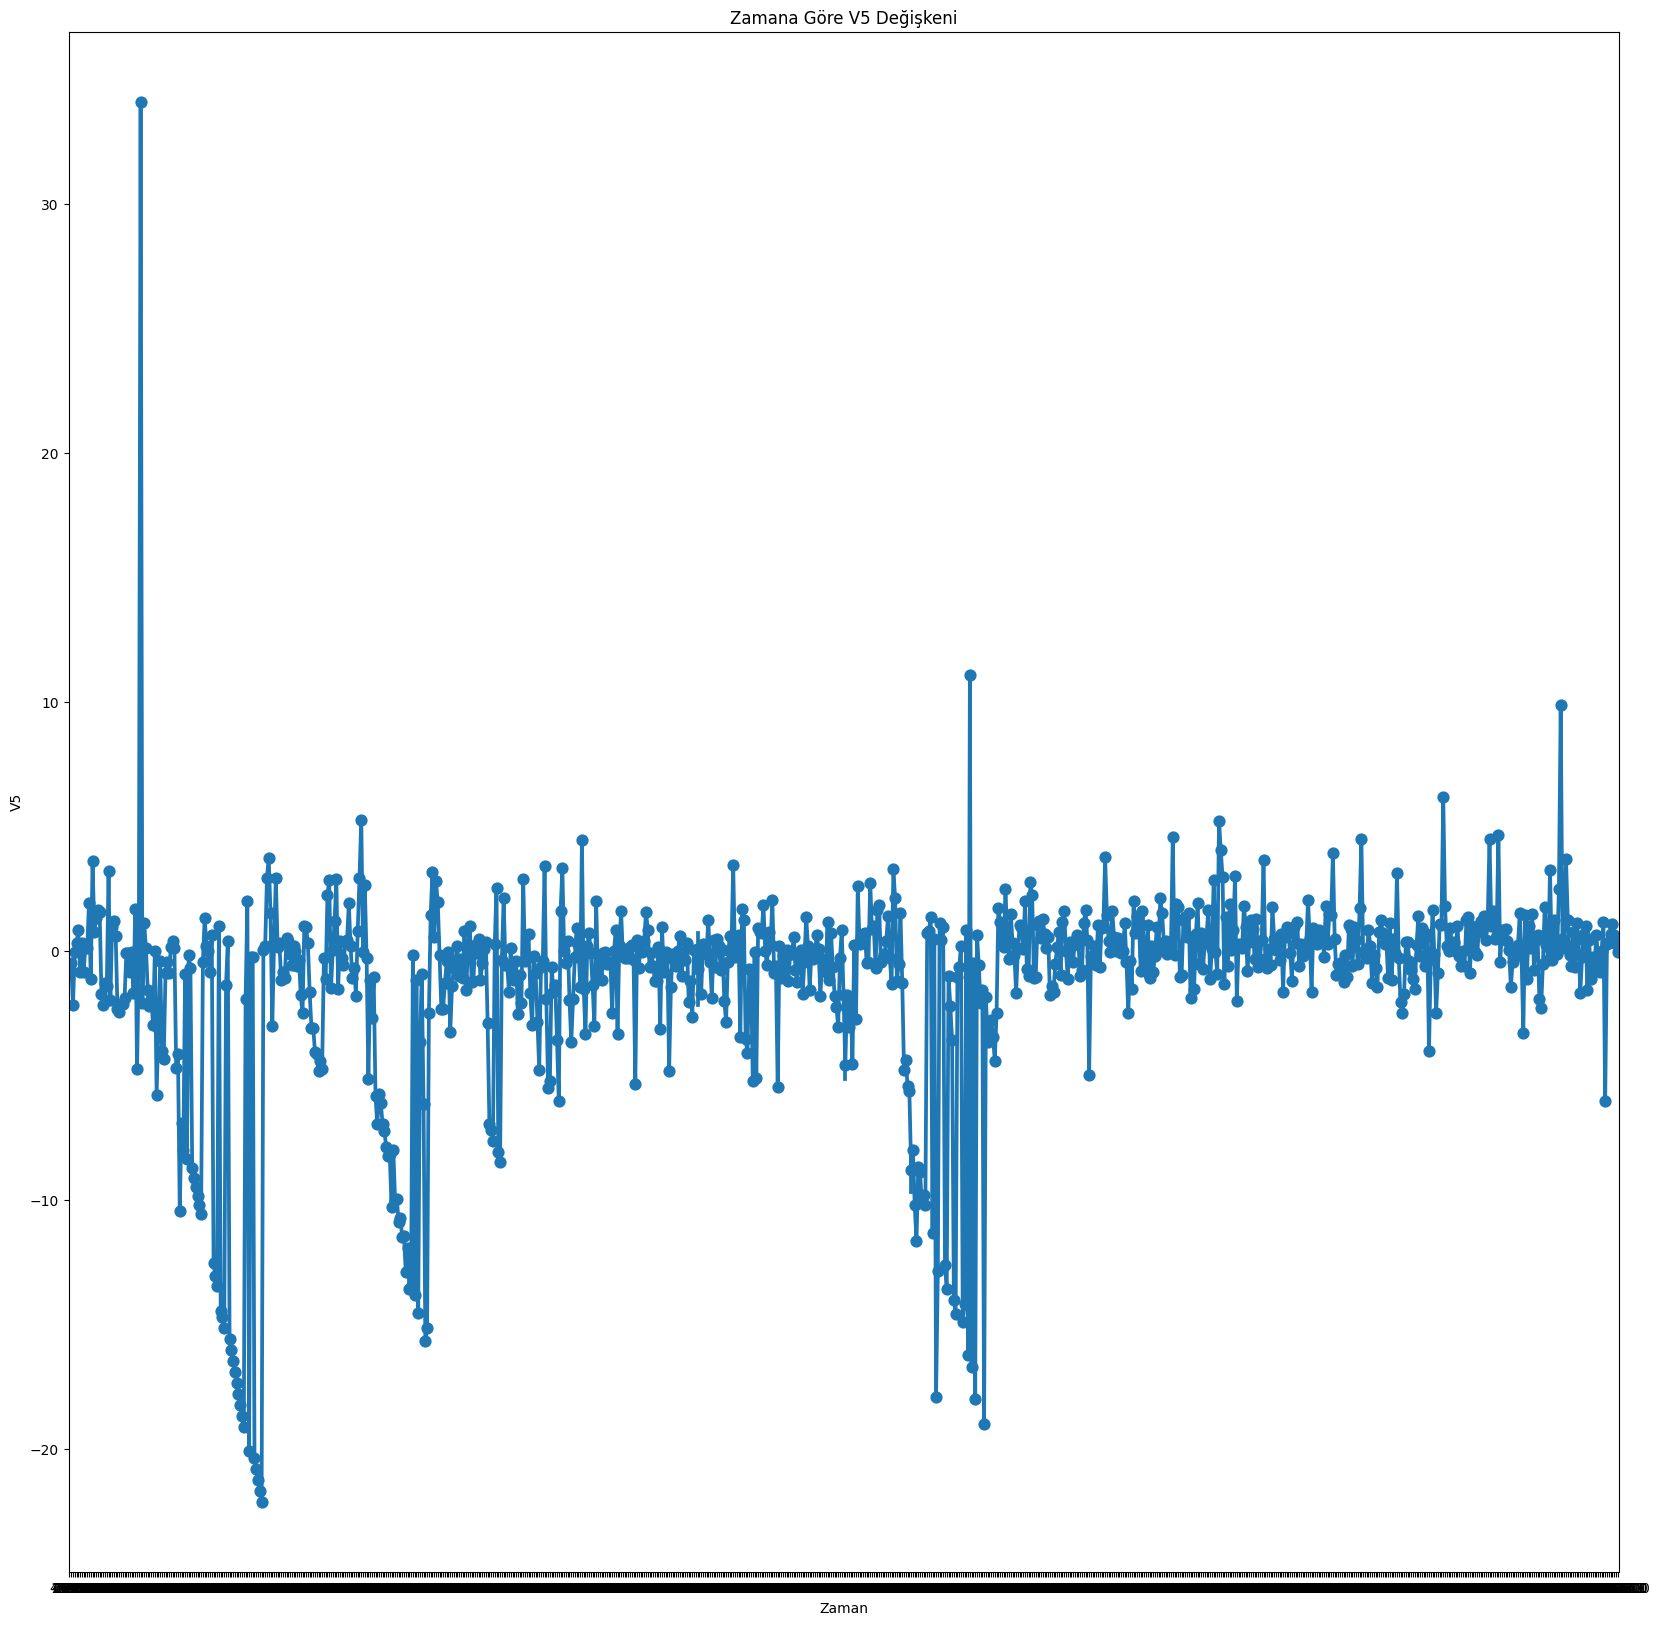

In [82]:
plt.figure(figsize=(20,20))
sns.pointplot(x="Time",y="V5",data=dataN)
plt.title("Zamana Göre V5 Değişkeni")
plt.xlabel("Zaman")
plt.ylabel("V5")
plt.show()

Bu grafikten V5 değişkeninin zamana göre hızlı düşen ve hızlı yükselen desenler oluşturduğu görünmektedir. Bu desenlere bakarak bir çıkarım yapamadım.

In [83]:
fig = px.parallel_coordinates(dataN, color="Class",
                              dimensions=['V4', 'V14', 'V11',
                                          'V10','V3',"V16","V17",'V12','V9','V1'],
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)
fig.show()

![alt text](parallelPlot1.png "Title")

<br>
Bu grafikte normal (koyu yeşil) ve dolandırıcı (açık yeşil) olan aktarımların değişkenlere göre dağılımı gösterilmektedir. V4 ve V14 gibi değişkenlerde ayrım çok net olarak görünmektedir. Dolandırıcı aktarımlar genel olarak grafikteki bütün değişkenlerde geniş bir dağılıma sahipken normal olan aktarımlar daha dar bir dağılıma sahiptir. Özellikle V17 değişkeninde bu dağılım farkı göze batmaktadır.

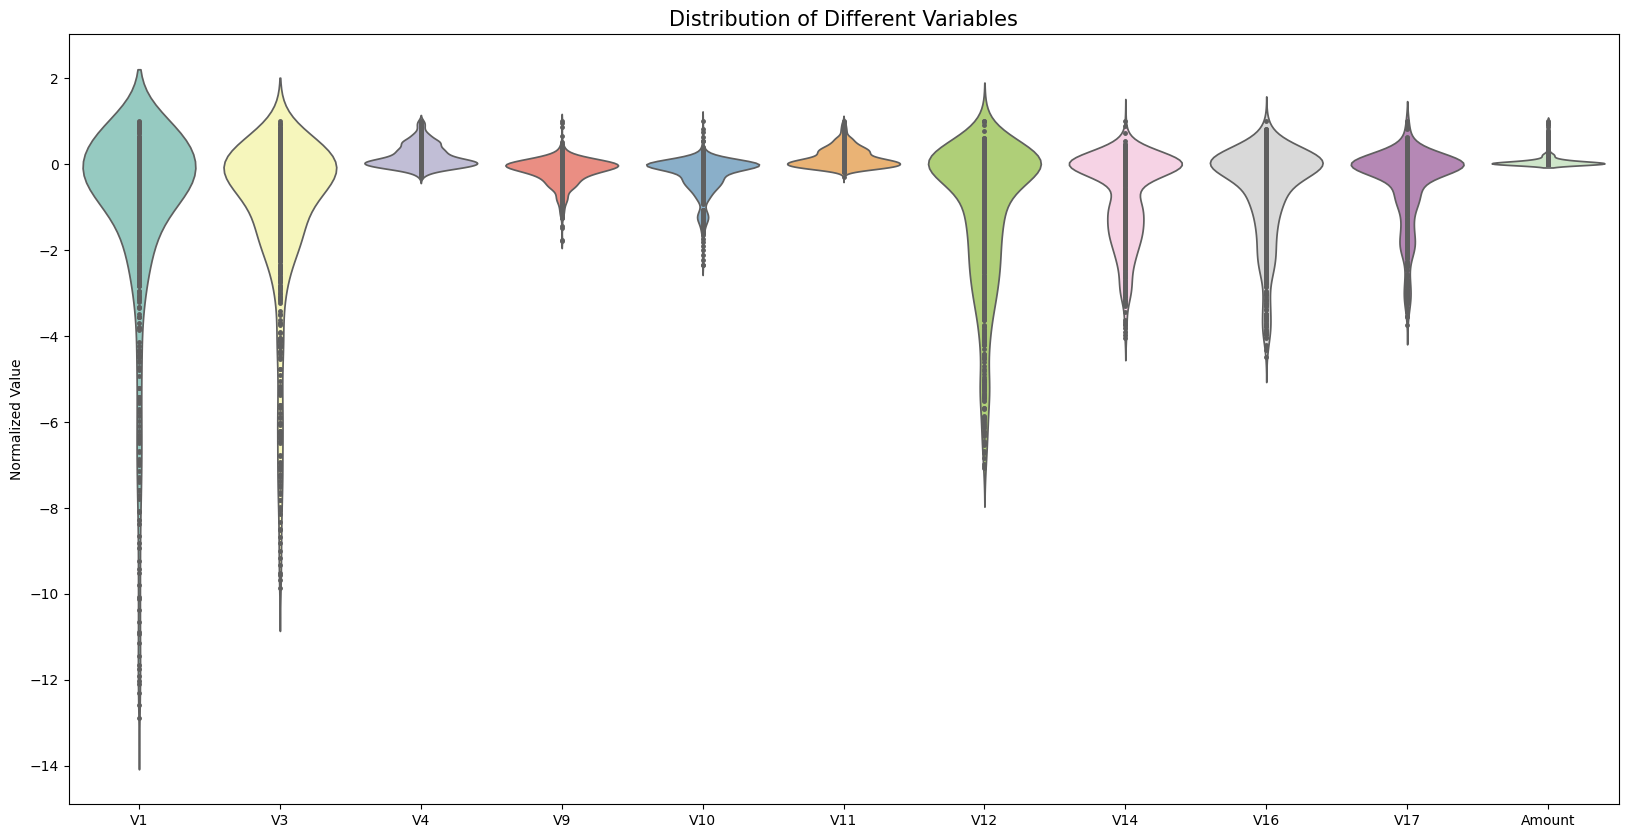

In [84]:
data3_norm = dataN.copy()

# normalize etmek için kullanılacak olan verilerin adı bir listeye yazıldı
numericalVariables_for_norm = ['V1','V3','V4', 'V9','V10', 'V11','V12','V14',"V16","V17",'Amount']

# listedeki her bir sütun için 
for var in numericalVariables_for_norm:
    data3_norm[var] = dataN[var] / dataN[var].max() # o veri, o sete ait en büyük değere bölündü

plt.figure(figsize=(20,10))
# Hesaplanan değerler için violinplot çizdiriliyor 
sns.violinplot(data=data3_norm[numericalVariables_for_norm],palette="Set3",inner="points",)
plt.ylabel("Normalized Value")
plt.title("Distribution of Different Variables",fontsize=15,color='black')
plt.show()

Bu grafikte ilişkili değişkenlerin dağılımı incelenmektedir. V1,V3 ve V12 çok geniş bir dağılım gösterirken Amount çok dar bir yayılım göstermektedir. V4 ile V11 'in yayılımı ise neredeyse aynıdır.

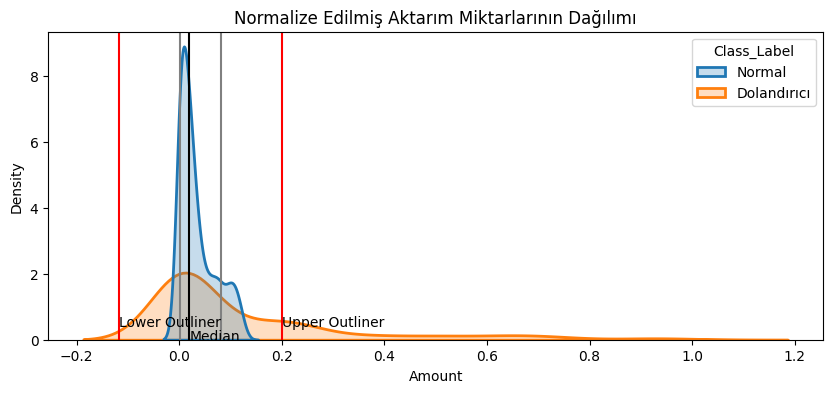

In [85]:
# 15'e 8 boyutunda dağılım grafiği çizdiriliyor
plt.figure(figsize=(10,4))



sns.kdeplot(x=data3_norm['Amount'], hue = data3_norm['Class_Label'], fill = True, linewidth = 2)

median = data3_norm['Amount'].median() # Mutluluk puanının medyanı bulunuyor
Q1 = data3_norm['Amount'].quantile(0.25) # Mutlluk puanının lower quartile'ı bulunuyor 
Q2 = data3_norm['Amount'].quantile(0.75) # Mutluluk puanının upper quartile'ı bulunuyor 
IQR = (Q2-Q1) * 1.5 # İki quartile arasındaki fark hesaplanıyor 


plt.axvline(median,c= 'black') # Mutluluk puanının medyanına çizgi çekiliyor 
plt.axvline(Q1,c= 'gray')      # Lower quartile'a çizgi çekiliyor 
plt.axvline(Q2,c= 'gray')      # Upper quartile'a çizgi çekiliyor
plt.axvline((Q1-IQR),c= 'red') # Tepe istisna noktasına kırmızı çizgi çekiliyor
plt.axvline((Q2+IQR),c= 'red') # Alt istisna noktasına kırmızı çizgi çekiliyor


plt.text(x=(Q1-IQR),y=0.4,s="Lower Outliner") # Lower outliner yazısı yazdırılıyor
plt.text(x=(Q2+IQR),y=0.4,s="Upper Outliner") # Upper Outliner yazısı yazdırılıyor 
plt.text(x=median,y=-0.02,s="Median")         # Medyan  yazısı yazdırılıyor
plt.title("Normalize Edilmiş Aktarım Miktarlarının Dağılımı")
plt.show()

Bu grafikte dolandırıcı ve normal olan aktarımların miktarları normalize edilerek gösterilmiştir.Grafiğe baktığımızda dolandırıcı aktarımların miktarlarının çok geniş olduğu görülmektedir. Normal akışlar ise daha dar bir alana yayılmaktadır.

In [86]:

fig = px.scatter_3d(data3_norm, x='V14', y='V4', z='V11',
              color='Class_Label')
fig.show()

![alt text](3dPlot1.png "Title")

<br>
Buradaki üç boyutlu grafikte X,Y ve Z eksenine Class ile en yüksek korelasyona sahip olan değişkenler yerleştirilmiştir. Bu sayede kümeler net şekilde görülebilmektedir. Kırmızı olan noktalar dolandırıcı aktarımları, mor olan noktalar ise normal olan aktarımları göstermektedir. Normal aktarımlar dark bir alanda bulunurken dolandırıcı olan aktarımlar daha geniş bir alana yayılmış durumdadır.

<a id="4"></a>
## 3. Preprocessing

Bu kısımda veri makine öğrenimine hazır hale getirilecektir. Eksik veri varsa çıkarılacak, gerekli değişkenler yeniden boyutlandırılacak, outlierlar varsa düzenlenecek ve eğitime hazır son veri paketleri oluşturulacaktır.
Outlierlara daha öncesinde bakmıştık o yüzden şimdi bakmayacağım. Veri setindeki eşitsizliği ise düzeltmiştik. Normal iletimlerden çok fazla vardı. Bu sorunu çözmek için undersampling kullanılmıştır. Normal olan verilerden normal olmayan kadarı rastgele şekilde seçilmiştir. Bu işlem yapılmadan önce normal olan verideki outlierlar ortadan kaldırılmıştır.

Eğer bu sorunu çözmeseydik şu sorunlar ortaya çıkabilirdi: 
* Model fazla olan veriye overfit olabilir ve anormal iletileri tespitte zorlşanabilirdi.
* Model testlerindeki ölçümler hataya sürükleyebilirdi, çünkü anormal veri normal veri sayısından daha fazla.

Ben undersampling ile çözdüm fakat farklı çözüm teknikleri de bulunmaktadır. 
# Dataset Dengesizlik Çözüm Teknikleri Karşılaştırma
| **Metot**             |**Açıklama**               |**Avantaj**        |**Dezavantaj** |
|-----------------------|---------------------------|-------------------|---------------|
|  Resampling           |Eldeki verinin bir kısmını alarak (undersampling) yada çoğaltarak (oversampling) kullanımıdır.|Kullanması kolay bir yöntemdir.|Overfitting veya bilgi kaybına sebep olabilir.|
|Class Weight Adjustment|Az olan verinin katsayısını eğitim esnasında ayarlayarak denge sağlanır.|Verisetini modifiye etmeye gerek duyulmaz.|Çok dengesiz durumlarda işe yaramayabilir.|
|SMOTE (Synthetic Minority Over-sampling Technique)| Az olan dataya sentetik yeni veriler ekler.|Kopyalama olmadan dengelemeyi sağlar.| Sentetik verinin gerçek hayata uygun olmaması durumunda gürültü oluşturabilir.|


Kayıp veri olmadığını en başta görmüştük.

In [87]:
dataN.isnull().value_counts()

Time   V1     V2     V3     V4     V5     V6     V7     V8     V9     V10    V11    V12    V13    V14    V15    V16    V17    V18    V19    V20    V21    V22    V23    V24    V25    V26    V27    V28    Amount  Class  Class_Label
False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False   False  False          878
Name: count, dtype: int64

In [88]:
features = dataN.columns.tolist()

for var in features:
    print(f"min {var} : {min(dataN[var])}    max {var}: {max(dataN[var])}")

min Time : 406.0    max Time: 172764.0
min V1 : -30.552380043581    max V1: 2.37290522322996
min V2 : -34.607648642371    max V2: 22.0577289904909
min V3 : -31.1036848245812    max V3: 3.15672517532603
min V4 : -3.69872353691432    max V4: 12.1146718424589
min V5 : -22.105531524316    max V5: 34.0993093435765
min V6 : -23.4967139298714    max V6: 6.47411462748849
min V7 : -43.5572415712451    max V7: 4.03151344147581
min V8 : -41.0442609210741    max V8: 20.0072083651213
min V9 : -13.4340663182301    max V9: 7.49657679827683
min V10 : -24.5882624372475    max V10: 10.4235051623587
min V11 : -3.6104263739062    max V11: 12.0189131816199
min V12 : -18.6837146333443    max V12: 2.63951879487794
min V13 : -3.12779501198771    max V13: 3.29357649647332
min V14 : -19.2143254902614    max V14: 4.7411576999073
min V15 : -4.49894467676621    max V15: 2.84202260112544
min V16 : -14.1298545174931    max V16: 3.13965565883069
min V17 : -25.1627993693248    max V17: 6.73938438478335
min V18 : -9.49

Verilerin yayıldığı aralık incelendiğinde normalleştirme işlemine ihtiyaç duyulduğu anlaşılmaktadır. Veriyi -1/1 gibi küçük bir aralığa sıkıştırdığımızda hem model daha hızlı bir şekilde eğitilecek hem de katsayıların büyük değişkenlerle yapacağı dengesizlik ortadan kalkacaktır.

In [89]:
def normalize_features(datan,features):
    data_normalized = datan.copy()
    for var in features:
        mean = np.mean(data[var])
        max = np.max(data[var])
        min = np.min(data[var])
        data_normalized[var] =  (data_normalized[var] - mean) / (max - min)
    
    return data_normalized

In [90]:
dataNN = dataN.drop(['Class_Label'],axis=1)
features = dataNN.columns.tolist()
features.remove("Class")
data_normalized = normalize_features(dataNN,features)

for var in features:
    print(f"min {var} : {min(data_normalized[var])}    max {var}: {max(data_normalized[var])}")

min Time : -0.5466703506436849    max Time: 0.45081795900028016
min V1 : -0.6209063611963384    max V1: 0.04681419236654981
min V2 : -0.499644799955856    max V2: 0.3158321546072581
min V3 : -0.7233197443046527    max V3: 0.0722583259099009
min V4 : -0.1954584806138783    max V4: 0.6451289619665781
min V5 : -0.38377840711164374    max V5: 0.589144904476873
min V6 : -0.5849455615768572    max V6: 0.1622560012100214
min V7 : -0.7345247710302703    max V7: 0.06908199978657714
min V8 : -0.44043909669664943    max V8: 0.21445145949952044
min V9 : -0.46293656165174973    max V9: 0.2580872141543522
min V10 : -0.5089831360732338    max V10: 0.21539728500688388
min V11 : -0.21468529720814863    max V11: 0.7147259897793412
min V12 : -0.7041834098534726    max V12: 0.09949319457530692
min V13 : -0.3019978734270384    max V13: 0.3177723785753508
min V14 : -0.6458806169955226    max V14: 0.1595869011116031
min V15 : -0.4360586350429657    max V15: 0.2749585464633018
min V16 : -0.6869739201192029   

Normalleştirme işleminden sonra veri aralığı bütün değişkenlerde eşitlenmiştir. Aynı zamanda boyut olarak dengesizlik sağlayan değişkenler ortadan kalkmıştır.

In [91]:
X = data_normalized.drop(['Class'], axis=1)
Y = data_normalized['Class']

In [92]:
# 
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.4, random_state=42, stratify=Y)

# 
X_val, X_test_use, y_val, y_test_use = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

#print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")

Bütün veri setinin 60%'ı eğitim, 20%'si cross-validation ve 20%'si de test için ayrılmıştır. Böylece eğitim, cross-validation ve test için üç farklı veriseti elde edilmiştir. Her bir verisetindeki normal ve normal olmayan aktarım sayısı eşittir. Örnek olarak y_train veriseti aşağıda gösterilmiştir.

In [93]:
print(pd.Series(y_train).value_counts())

Class
0    263
1    263
Name: count, dtype: int64


<a id="5"></a>
## 6. Training
Bu bölümde hazırlanan veri seti kullanarak birkaç model eğitilecek ve karşılaştırmaları yapılacaktır.
Problemimiz sınıflandırma üzerine olduğu için sınıflandırma ile ilgili modeller eğiteceğim. 

İlk modeller olarak random forest, XGBclassifier ve sigmoid aktivasyona sahip nöral ağ kullanılacaktır. Bu modellere verilecek olan veri undersampling ile düzeltilmiştir.


In [94]:
rf_model_use = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model_use.fit(X_train, y_train)

xgb_model_use = XGBClassifier(scale_pos_weight=5, use_label_encoder=False, eval_metric='logloss')
xgb_model_use.fit(X_train, y_train)


nn_model_use = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification için sigmoid çıkış
])


c:\Users\LENOVO\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:158: UserWarning:

[18:11:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Random Forest Model
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        88
           1       0.95      0.98      0.96        88

    accuracy                           0.96       176
   macro avg       0.96      0.96      0.96       176
weighted avg       0.96      0.96      0.96       176

XGBoost Model
              precision    recall  f1-score   support

           0       0.99      0.92      0.95        88
           1       0.93      0.99      0.96        88

    accuracy                           0.95       176
   macro avg       0.96      0.95      0.95       176
weighted avg       0.96      0.95      0.95       176



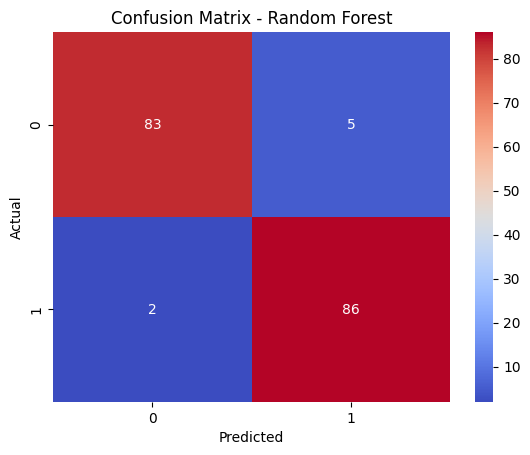

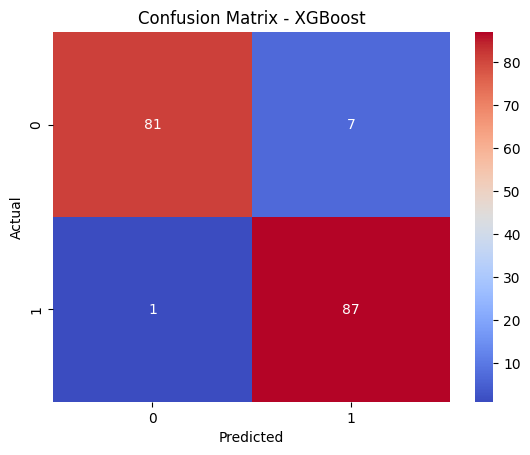

In [95]:
rf_preds = rf_model_use.predict(X_val)
xgb_preds = xgb_model_use.predict(X_val)

print("Random Forest Model")
print(classification_report(y_val, rf_preds))

print("XGBoost Model")
print(classification_report(y_val, xgb_preds))

sns.heatmap(confusion_matrix(y_val, rf_preds), annot=True, fmt='d', cmap='coolwarm')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


sns.heatmap(confusion_matrix(y_val, xgb_preds), annot=True, fmt='d', cmap='coolwarm')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [96]:
def f1_score2(y_true, y_pred):
    y_pred = tf.keras.backend.round(y_pred)  # 0.5’ten büyük olanları 1 olarak kabul et
    tp = tf.keras.backend.sum(y_true * y_pred)  # True Positives
    precision = tp / (tf.keras.backend.sum(y_pred) + tf.keras.backend.epsilon())  # Precision hesaplama
    recall = tp / (tf.keras.backend.sum(y_true) + tf.keras.backend.epsilon())  # Recall hesaplama
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())  # F1 skoru
    return f1

In [97]:
nn_model_use.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_score2]) 
nn_model_use.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val)) 


Epoch 1/20
17/17 [==============================] - 1s 13ms/step - loss: 0.6829 - accuracy: 0.5741 - f1_score2: 0.6569 - val_loss: 0.6594 - val_accuracy: 0.8295 - val_f1_score2: 0.8370
Epoch 2/20
17/17 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.8954 - f1_score2: 0.8873 - val_loss: 0.6101 - val_accuracy: 0.9148 - val_f1_score2: 0.9192
Epoch 3/20
17/17 [==============================] - 0s 2ms/step - loss: 0.5688 - accuracy: 0.9240 - f1_score2: 0.9120 - val_loss: 0.5345 - val_accuracy: 0.9318 - val_f1_score2: 0.9360
Epoch 4/20
17/17 [==============================] - 0s 3ms/step - loss: 0.4801 - accuracy: 0.9240 - f1_score2: 0.9161 - val_loss: 0.4326 - val_accuracy: 0.9432 - val_f1_score2: 0.9479
Epoch 5/20
17/17 [==============================] - 0s 2ms/step - loss: 0.3784 - accuracy: 0.9278 - f1_score2: 0.9100 - val_loss: 0.3235 - val_accuracy: 0.9375 - val_f1_score2: 0.9425
Epoch 6/20
17/17 [==============================] - 0s 3ms/step - loss: 0.2864 

In [98]:
test_loss, test_acc, test_f1_score= nn_model_use.evaluate(X_val, y_val)
print(f"Test Loss : {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"F1 Score: {test_f1_score:.4f}")

6/6 [==============================] - 0s 0s/step - loss: 0.0889 - accuracy: 0.9659 - f1_score2: 0.9617
Test Loss : 0.0889
Test Accuracy: 0.9659
F1 Score: 0.9617


Şimdi epoch parametresini arttırıp tekrar bir deneme yapacağım.

In [99]:
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification için sigmoid çıkış
])
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_score2]) 

In [100]:
nn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
17/17 [==============================] - 1s 10ms/step - loss: 0.6611 - accuracy: 0.7700 - f1_score2: 0.7465 - val_loss: 0.6219 - val_accuracy: 0.8920 - val_f1_score2: 0.8915
Epoch 2/100
17/17 [==============================] - 0s 3ms/step - loss: 0.5799 - accuracy: 0.8631 - f1_score2: 0.8717 - val_loss: 0.5355 - val_accuracy: 0.9148 - val_f1_score2: 0.9092
Epoch 3/100
17/17 [==============================] - 0s 2ms/step - loss: 0.4846 - accuracy: 0.9392 - f1_score2: 0.9353 - val_loss: 0.4347 - val_accuracy: 0.9602 - val_f1_score2: 0.9636
Epoch 4/100
17/17 [==============================] - 0s 3ms/step - loss: 0.3865 - accuracy: 0.9335 - f1_score2: 0.9170 - val_loss: 0.3329 - val_accuracy: 0.9545 - val_f1_score2: 0.9578
Epoch 5/100
17/17 [==============================] - 0s 3ms/step - loss: 0.3027 - accuracy: 0.9335 - f1_score2: 0.9193 - val_loss: 0.2496 - val_accuracy: 0.9545 - val_f1_score2: 0.9578
Epoch 6/100
17/17 [==============================] - 0s 3ms/step - loss: 0

In [101]:
test_loss, test_acc, test_f1_score= nn_model.evaluate(X_val, y_val)
print(f"Test Loss : {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"F1 Score: {test_f1_score:.4f}")

6/6 [==============================] - 0s 0s/step - loss: 0.0726 - accuracy: 0.9659 - f1_score2: 0.9630
Test Loss : 0.0726
Test Accuracy: 0.9659
F1 Score: 0.9630


Accuracy'de düşüş yaşandı. Bunun sebebi aynı veriyi tekrar tekrar eğitime verince modelin overfittinge eğilimli olması. Aynı zamanda F1 skorundaki düşüş'te modelin daha kötü bir hale geldiğini gösteriyor.
Daha düşük fakat en baştaki epoch'tan daha yüksek bir model deneyeceğim.

In [102]:
nn_model.fit(X_train, y_train, epochs=32, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/32
17/17 [==============================] - 0s 4ms/step - loss: 0.0306 - accuracy: 0.9924 - f1_score2: 0.9901 - val_loss: 0.0697 - val_accuracy: 0.9659 - val_f1_score2: 0.9630
Epoch 2/32
17/17 [==============================] - 0s 3ms/step - loss: 0.0313 - accuracy: 0.9924 - f1_score2: 0.9918 - val_loss: 0.0728 - val_accuracy: 0.9659 - val_f1_score2: 0.9630
Epoch 3/32
17/17 [==============================] - 0s 3ms/step - loss: 0.0281 - accuracy: 0.9924 - f1_score2: 0.9900 - val_loss: 0.0708 - val_accuracy: 0.9659 - val_f1_score2: 0.9630
Epoch 4/32
17/17 [==============================] - 0s 2ms/step - loss: 0.0281 - accuracy: 0.9943 - f1_score2: 0.9939 - val_loss: 0.0715 - val_accuracy: 0.9659 - val_f1_score2: 0.9630
Epoch 5/32
17/17 [==============================] - 0s 3ms/step - loss: 0.0272 - accuracy: 0.9962 - f1_score2: 0.9959 - val_loss: 0.0707 - val_accuracy: 0.9659 - val_f1_score2: 0.9630
Epoch 6/32
17/17 [==============================] - 0s 3ms/step - loss: 0.0266 -

In [103]:
test_loss, test_acc, test_f1_score= nn_model.evaluate(X_val, y_val)
print(f"Test Loss : {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"F1 Score: {test_f1_score:.4f}")

6/6 [==============================] - 0s 0s/step - loss: 0.0752 - accuracy: 0.9659 - f1_score2: 0.9630
Test Loss : 0.0752
Test Accuracy: 0.9659
F1 Score: 0.9630


Yine düşüş yaşandı. Epoch parametresini 20 olarak bırakıyorum.
Şimdi sırada sinir ağının yapısını değiştirip tekrar denemek olacak.

In [104]:
nn_model = Sequential([
    Dense(30, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(30, activation='relu'),
    Dense(1, activation='sigmoid')  
])

In [105]:
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_score2])
nn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
17/17 [==============================] - 1s 11ms/step - loss: 0.6694 - accuracy: 0.7814 - f1_score2: 0.8063 - val_loss: 0.6471 - val_accuracy: 0.8920 - val_f1_score2: 0.9054
Epoch 2/20
17/17 [==============================] - 0s 3ms/step - loss: 0.6186 - accuracy: 0.9106 - f1_score2: 0.9106 - val_loss: 0.5900 - val_accuracy: 0.9261 - val_f1_score2: 0.9366
Epoch 3/20
17/17 [==============================] - 0s 3ms/step - loss: 0.5524 - accuracy: 0.9297 - f1_score2: 0.9295 - val_loss: 0.5166 - val_accuracy: 0.9432 - val_f1_score2: 0.9488
Epoch 4/20
17/17 [==============================] - 0s 3ms/step - loss: 0.4733 - accuracy: 0.9278 - f1_score2: 0.9218 - val_loss: 0.4329 - val_accuracy: 0.9432 - val_f1_score2: 0.9464
Epoch 5/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3929 - accuracy: 0.9240 - f1_score2: 0.9140 - val_loss: 0.3501 - val_accuracy: 0.9375 - val_f1_score2: 0.9407
Epoch 6/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3192 

In [106]:
test_loss, test_acc, test_f1_score= nn_model.evaluate(X_val, y_val)
print(f"Test Loss : {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"F1 Score: {test_f1_score:.4f}")

6/6 [==============================] - 0s 679us/step - loss: 0.0918 - accuracy: 0.9659 - f1_score2: 0.9617
Test Loss : 0.0918
Test Accuracy: 0.9659
F1 Score: 0.9617


En baştaki nöral ağdan daha düşük bir f1 skoruna sahip bir model eğittik. Şimdi epoch sayısını arttırıp tekrar deneme yapacağım.

In [107]:
nn_model.fit(X_train, y_train, epochs=32, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/32
17/17 [==============================] - 0s 5ms/step - loss: 0.1062 - accuracy: 0.9582 - f1_score2: 0.9551 - val_loss: 0.0910 - val_accuracy: 0.9659 - val_f1_score2: 0.9617
Epoch 2/32
17/17 [==============================] - 0s 3ms/step - loss: 0.1036 - accuracy: 0.9582 - f1_score2: 0.9582 - val_loss: 0.0881 - val_accuracy: 0.9659 - val_f1_score2: 0.9617
Epoch 3/32
17/17 [==============================] - 0s 2ms/step - loss: 0.1023 - accuracy: 0.9563 - f1_score2: 0.9525 - val_loss: 0.0884 - val_accuracy: 0.9659 - val_f1_score2: 0.9617
Epoch 4/32
17/17 [==============================] - 0s 3ms/step - loss: 0.1011 - accuracy: 0.9601 - f1_score2: 0.9613 - val_loss: 0.0880 - val_accuracy: 0.9659 - val_f1_score2: 0.9617
Epoch 5/32
17/17 [==============================] - 0s 3ms/step - loss: 0.0988 - accuracy: 0.9601 - f1_score2: 0.9584 - val_loss: 0.0870 - val_accuracy: 0.9659 - val_f1_score2: 0.9617
Epoch 6/32
17/17 [==============================] - 0s 2ms/step - loss: 0.0981 -

In [108]:
test_loss, test_acc, test_f1_score= nn_model.evaluate(X_val, y_val)
print(f"Test Loss : {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"F1 Score: {test_f1_score:.4f}")

6/6 [==============================] - 0s 1ms/step - loss: 0.0777 - accuracy: 0.9602 - f1_score2: 0.9570
Test Loss : 0.0777
Test Accuracy: 0.9602
F1 Score: 0.9570


Skor daha kötü bir hale geldi. Şimdi son olarak da logistic regression deneyeceğim. Bunun için yine aynı veriyi kullanacağım.

In [109]:
lr_model = Sequential([
    InputLayer(input_shape=(X_train.shape[1],)),  # Giriş katmanı
    Dense(1, activation='sigmoid')  # Çıkış katmanı (sigmoid aktivasyonu ile lojistik regresyon)
])

In [110]:
lr_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_score2])

lr_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
17/17 [==============================] - 0s 993us/step - loss: 0.7483 - accuracy: 0.3061 - f1_score2: 0.1395
Epoch 2/50
17/17 [==============================] - 0s 1ms/step - loss: 0.7366 - accuracy: 0.3099 - f1_score2: 0.1754
Epoch 3/50
17/17 [==============================] - 0s 2ms/step - loss: 0.7257 - accuracy: 0.3270 - f1_score2: 0.2126
Epoch 4/50
17/17 [==============================] - 0s 48us/step - loss: 0.7149 - accuracy: 0.3441 - f1_score2: 0.2666
Epoch 5/50
17/17 [==============================] - 0s 979us/step - loss: 0.7046 - accuracy: 0.4125 - f1_score2: 0.3660
Epoch 6/50
17/17 [==============================] - 0s 1ms/step - loss: 0.6950 - accuracy: 0.5247 - f1_score2: 0.5254
Epoch 7/50
17/17 [==============================] - 0s 983us/step - loss: 0.6857 - accuracy: 0.5817 - f1_score2: 0.5894
Epoch 8/50
17/17 [==============================] - 0s 992us/step - loss: 0.6767 - accuracy: 0.6407 - f1_score2: 0.6618
Epoch 9/50
17/17 [=============================

In [111]:
test_loss, test_acc, test_f1_score= lr_model.evaluate(X_val, y_val)
print(f"Test Loss : {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"F1 Score: {test_f1_score:.4f}")

6/6 [==============================] - 0s 3ms/step - loss: 0.4746 - accuracy: 0.9205 - f1_score2: 0.9246
Test Loss : 0.4746
Test Accuracy: 0.9205
F1 Score: 0.9246


Önceki sonuçlarımızdan daha iyi olmayan yeni bir model elde ettik. Epoch sayısını değiştirip tekrar deneyeceğim.

In [112]:
lr_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
17/17 [==============================] - 0s 1ms/step - loss: 0.4710 - accuracy: 0.9011 - f1_score2: 0.8887
Epoch 2/20
17/17 [==============================] - 0s 1ms/step - loss: 0.4682 - accuracy: 0.9011 - f1_score2: 0.8811
Epoch 3/20
17/17 [==============================] - 0s 1ms/step - loss: 0.4655 - accuracy: 0.9011 - f1_score2: 0.8908
Epoch 4/20
17/17 [==============================] - 0s 979us/step - loss: 0.4628 - accuracy: 0.9011 - f1_score2: 0.8885
Epoch 5/20
17/17 [==============================] - 0s 978us/step - loss: 0.4602 - accuracy: 0.9011 - f1_score2: 0.8829
Epoch 6/20
17/17 [==============================] - 0s 977us/step - loss: 0.4576 - accuracy: 0.9011 - f1_score2: 0.8870
Epoch 7/20
17/17 [==============================] - 0s 1ms/step - loss: 0.4550 - accuracy: 0.9011 - f1_score2: 0.8773
Epoch 8/20
17/17 [==============================] - 0s 998us/step - loss: 0.4525 - accuracy: 0.9011 - f1_score2: 0.8890
Epoch 9/20
17/17 [==============================

In [113]:
test_loss, test_acc, test_f1_score= lr_model.evaluate(X_val, y_val)
print(f"Test Loss : {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"F1 Score: {test_f1_score:.4f}")

6/6 [==============================] - 0s 3ms/step - loss: 0.4239 - accuracy: 0.9148 - f1_score2: 0.9176
Test Loss : 0.4239
Test Accuracy: 0.9148
F1 Score: 0.9176


Yine bir önceki logistic regressionun sonuçları ile aynı olan bir model ortaya çıktı. Son olarak 30 epoch deneyeceğim. Sonrasında ise küçük bir tablo ile şimdiye kadar yaptığımız modelleri karşılaştıracağım.

In [114]:
lr_model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
17/17 [==============================] - 0s 1ms/step - loss: 0.4231 - accuracy: 0.9011 - f1_score2: 0.8808
Epoch 2/30
17/17 [==============================] - 0s 1ms/step - loss: 0.4211 - accuracy: 0.9011 - f1_score2: 0.8840
Epoch 3/30
17/17 [==============================] - 0s 2ms/step - loss: 0.4190 - accuracy: 0.9011 - f1_score2: 0.8906
Epoch 4/30
17/17 [==============================] - 0s 820us/step - loss: 0.4170 - accuracy: 0.9011 - f1_score2: 0.8791
Epoch 5/30
17/17 [==============================] - 0s 1ms/step - loss: 0.4151 - accuracy: 0.9011 - f1_score2: 0.8875
Epoch 6/30
17/17 [==============================] - 0s 939us/step - loss: 0.4131 - accuracy: 0.9011 - f1_score2: 0.8881
Epoch 7/30
17/17 [==============================] - 0s 947us/step - loss: 0.4112 - accuracy: 0.9030 - f1_score2: 0.8931
Epoch 8/30
17/17 [==============================] - 0s 977us/step - loss: 0.4093 - accuracy: 0.9011 - f1_score2: 0.8833
Epoch 9/30
17/17 [==============================

In [115]:
test_loss, test_acc, test_f1_score= lr_model.evaluate(X_val, y_val)
print(f"Test Loss : {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"F1 Score: {test_f1_score:.4f}")

6/6 [==============================] - 0s 2ms/step - loss: 0.3679 - accuracy: 0.9091 - f1_score2: 0.9104
Test Loss : 0.3679
Test Accuracy: 0.9091
F1 Score: 0.9104


Bir öncekinden daha kötü bir model elde edilmiştir.

<br>
Şimdiye kadar undersampling ile hazırlanmış verisetiyle model eğitmiştik. Şimdi farklı bir imbalans düzeltme tekniği olan SMOTE kullanılacaktır. Bütün modeller hazırlandıktan sonra en sonda bir tablo içerisinde karşılaştırılacaktır.  


In [116]:
data.shape

(274617, 31)

In [117]:
db_normal = data[data["Class"] == 0]
db_fraud = data[data["Class"] == 1]

In [118]:
while(len(detect_outliers(db_normal,"Amount"))>1): # outlier kalmayana kadar temizlik 
    db_normal = db_normal.drop(detect_outliers(db_normal,"Amount"),axis = 0).reset_index(drop = True)

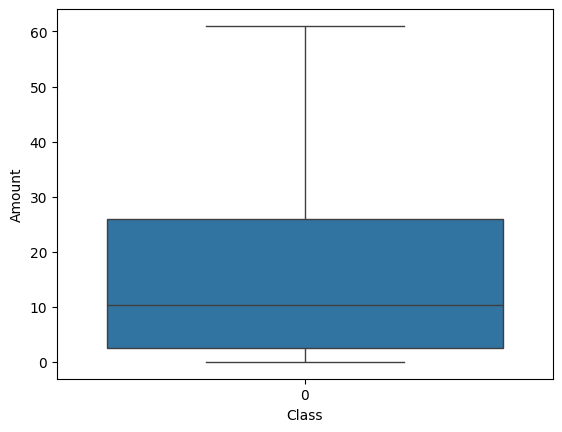

In [119]:
sns.boxplot(x="Class",y="Amount",data=db_normal) # normal olan Amount verilerinin dağılımı kontrol ediliyor
plt.show()

In [120]:
dataNew = pd.concat([db_normal,db_fraud],axis=0) # Ayrılan veriler dikey olarak birleştiriliyor
dataNew.shape # yeni verinin şekli kontrol ediliyor

(200902, 31)

In [121]:
X = dataNew.drop(['Class'], axis=1)
Y = dataNew['Class']


features = dataNew.columns.tolist()
features.remove("Class")
data_normalized = normalize_features(dataNew,features)

for var in features:
    print(f"min {var} : {min(data_normalized[var])}    max {var}: {max(data_normalized[var])}")

X_train, x_t, y_train, y_t = train_test_split(X, Y, test_size=0.4, random_state=42, stratify=Y)
X_val, x_test, y_val, y_test = train_test_split(x_t, y_t, test_size=0.5, random_state=42, stratify=y_t)


min Time : -0.5490199964606208    max Time: 0.45095685431950794
min V1 : -0.6938298102129767    max V1: 0.04847764411916123
min V2 : -0.5141669364227776    max V2: 0.3158321546072581
min V3 : -0.7831684944787354    max V3: 0.09709100905877166
min V4 : -0.29440398989548927    max V4: 0.6451289619665781
min V5 : -0.4108550955231271    max V5: 0.589144904476873
min V6 : -0.5849455615768572    max V6: 0.22357737293240548
min V7 : -0.7345247710302703    max V7: 0.11061498997443076
min V8 : -0.44516493909130006    max V8: 0.21445145949952044
min V9 : -0.46293656165174973    max V9: 0.3578600601947022
min V10 : -0.5089831360732338    max V10: 0.31694686645312703
min V11 : -0.23846219417699127    max V11: 0.7147259897793412
min V12 : -0.7041834098534726    max V12: 0.1826729299019576
min V13 : -0.3824892704489702    max V13: 0.44087304288073886
min V14 : -0.6458806169955226    max V14: 0.25798840216322017
min V15 : -0.4360586350429657    max V15: 0.3756280898320064
min V16 : -0.686973920119202

In [122]:
print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(x_test)}")

Train size: 120541, Validation size: 40180, Test size: 40181


In [123]:
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(pd.Series(y_train_resampled).value_counts())
print(pd.Series(y_val).value_counts())

Class
0    120278
1     60139
Name: count, dtype: int64
Class
0    40092
1       88
Name: count, dtype: int64


Bu sayede sentetik veri ile dengesizlik sorununu farklı bir şekilde çözmüş olduk. Şimdi denediğimiz modelleri tekrar deneyelim.

In [124]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_resampled, y_train_resampled)

xgb_model = XGBClassifier(scale_pos_weight=4, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_resampled, y_train_resampled)


nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  
])

c:\Users\LENOVO\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:158: UserWarning:

[18:15:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Random Forest Model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40092
           1       0.88      0.83      0.85        88

    accuracy                           1.00     40180
   macro avg       0.94      0.91      0.93     40180
weighted avg       1.00      1.00      1.00     40180

XGBoost Model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40092
           1       0.89      0.85      0.87        88

    accuracy                           1.00     40180
   macro avg       0.95      0.93      0.94     40180
weighted avg       1.00      1.00      1.00     40180



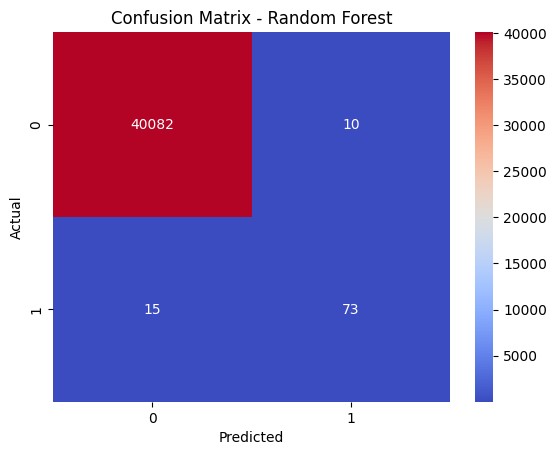

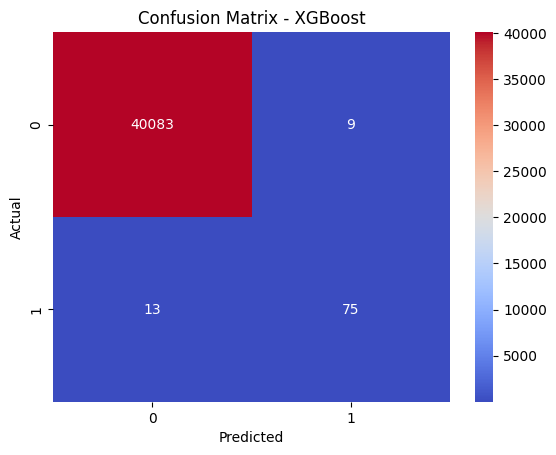

In [125]:
rf_preds = rf_model.predict(X_val)
xgb_preds = xgb_model.predict(X_val)


print("Random Forest Model")
print(classification_report(y_val, rf_preds))

print("XGBoost Model")
print(classification_report(y_val, xgb_preds))

sns.heatmap(confusion_matrix(y_val, rf_preds), annot=True, fmt='d', cmap='coolwarm')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


sns.heatmap(confusion_matrix(y_val, xgb_preds), annot=True, fmt='d', cmap='coolwarm')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Random forest modeli normal aktarımlar için 1 gibi bir f1 skoruna sahipken dolandırıcılık ile ilgili olan aktarımlarda 0.85 gibi bir skora sahip olmuştur. Buradan Random forestın dolandırıcı aktarımları çok iyi tespit edemediği çıkarımına ulaşabiliriz.
XGBoost ise yine aynı şekilde normal aktarımlarda 1 gibi bir f1 skoruna sahip olurken, dolandırıcı aktarımlarda 0.87 puanına sahip olmuştur. Buradan da yine random forestta olduğu gibi dolandırıcı amaçlı aktarımları çok iyi tespit edemediği anlaşılmaktadır.
<br>
Alt kısımda bulunan grafiklerde de cross-eval verisetinde bulunan verilerle tahmin edilenler arasındaki ilişkiler gösterilmektedir.
İki model de normal aktarımlar da çok iyi tespit yaparken normal olmayan aktarımlarda yukardaki modellere kıyasla daha kötü durumdadırlar.


In [126]:
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_score2])

nn_model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
5639/5639 [==============================] - 5s 884us/step - loss: 38.0492 - accuracy: 0.7916 - f1_score2: 0.6974
Epoch 2/10
5639/5639 [==============================] - 5s 803us/step - loss: 15.1591 - accuracy: 0.9023 - f1_score2: 0.8665
Epoch 3/10
5639/5639 [==============================] - 5s 808us/step - loss: 8.2897 - accuracy: 0.9356 - f1_score2: 0.9097
Epoch 4/10
5639/5639 [==============================] - 4s 788us/step - loss: 5.2011 - accuracy: 0.9478 - f1_score2: 0.9255
Epoch 5/10
5639/5639 [==============================] - 4s 775us/step - loss: 2.4993 - accuracy: 0.9574 - f1_score2: 0.9386
Epoch 6/10
5639/5639 [==============================] - 4s 786us/step - loss: 1.3123 - accuracy: 0.9596 - f1_score2: 0.9414
Epoch 7/10
5639/5639 [==============================] - 5s 837us/step - loss: 0.5893 - accuracy: 0.9653 - f1_score2: 0.9489
Epoch 8/10
5639/5639 [==============================] - 5s 843us/step - loss: 0.2492 - accuracy: 0.9728 - f1_score2: 0.9583
Epoch 

In [127]:
test_loss, test_acc, test_f1_score= nn_model.evaluate(X_val, y_val)

y_pred_prob = nn_model.predict(X_val)

y_pred = (y_pred_prob > 0.5).astype(int)

y_true = np.array(y_val).astype(int)

f1 = f1_score(y_true, y_pred)

print(f"Test Loss : {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"F1 Score: {f1:.4f}")

1256/1256 [==============================] - 1s 746us/step
Test Loss : 0.0354
Test Accuracy: 0.9984
F1 Score: 0.6832


Yeni veri setiyle oluşturulan bu NN modeli F1 skoru olarak şimdiye kadar ki en düşük model olmuştur. Veri sayısı fazla olduğu için epoch sayısını azaltıp tekrar deneyeceğim.

In [128]:
nn_model.fit(X_train_resampled, y_train_resampled, epochs=5, batch_size=32, verbose=1)

Epoch 1/5
5639/5639 [==============================] - 5s 904us/step - loss: 0.0777 - accuracy: 0.9787 - f1_score2: 0.9653
Epoch 2/5
5639/5639 [==============================] - 4s 774us/step - loss: 0.0747 - accuracy: 0.9799 - f1_score2: 0.9671
Epoch 3/5
5639/5639 [==============================] - 5s 860us/step - loss: 0.0649 - accuracy: 0.9820 - f1_score2: 0.9711
Epoch 4/5
5639/5639 [==============================] - 5s 857us/step - loss: 0.0689 - accuracy: 0.9813 - f1_score2: 0.9697
Epoch 5/5
5639/5639 [==============================] - 5s 901us/step - loss: 0.0660 - accuracy: 0.9814 - f1_score2: 0.9701


In [129]:
test_loss, test_acc, test_f1_score= nn_model.evaluate(X_val, y_val)

y_pred_prob = nn_model.predict(X_val)

y_pred = (y_pred_prob > 0.5).astype(int)

y_true = np.array(y_val).astype(int)

f1 = f1_score(y_true, y_pred)

print(f"Test Loss : {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"F1 Score: {f1:.4f}")

1256/1256 [==============================] - 1s 668us/step
Test Loss : 0.1517
Test Accuracy: 0.9630
F1 Score: 0.0938


Epoch sayısını 5'e çekince F1 puanında çok büyük bir düşüş olmuştur. Şimdi Epoch sayısını yükseltip deneyeceğim.

In [130]:
nn_model.fit(X_train_resampled, y_train_resampled, epochs=15, batch_size=32, verbose=1)

Epoch 1/15
5639/5639 [==============================] - 5s 905us/step - loss: 0.0629 - accuracy: 0.9828 - f1_score2: 0.9721
Epoch 2/15
5639/5639 [==============================] - 5s 917us/step - loss: 0.0628 - accuracy: 0.9826 - f1_score2: 0.9723
Epoch 3/15
5639/5639 [==============================] - 5s 964us/step - loss: 0.0618 - accuracy: 0.9834 - f1_score2: 0.9731
Epoch 4/15
5639/5639 [==============================] - 5s 873us/step - loss: 0.0563 - accuracy: 0.9838 - f1_score2: 0.9738
Epoch 5/15
5639/5639 [==============================] - 5s 961us/step - loss: 0.0670 - accuracy: 0.9834 - f1_score2: 0.9735
Epoch 6/15
5639/5639 [==============================] - 5s 948us/step - loss: 0.0574 - accuracy: 0.9845 - f1_score2: 0.9751
Epoch 7/15
5639/5639 [==============================] - 5s 880us/step - loss: 0.0533 - accuracy: 0.9851 - f1_score2: 0.9759
Epoch 8/15
5639/5639 [==============================] - 5s 965us/step - loss: 0.0558 - accuracy: 0.9842 - f1_score2: 0.9747
Epoch 9/

In [131]:
test_loss, test_acc, test_f1_score= nn_model.evaluate(X_val, y_val)


y_pred_prob = nn_model.predict(X_val)

y_pred = (y_pred_prob > 0.5).astype(int)

y_true = np.array(y_val).astype(int)

f1 = f1_score(y_true, y_pred)

print(f"Test Loss : {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"F1 Score: {f1:.4f}")

1256/1256 [==============================] - 1s 669us/step
Test Loss : 2.6325
Test Accuracy: 0.3839
F1 Score: 0.0064


Düşük epoch sayılı modele göre F1 puanı çok yüksek çıktı. fakat en baştaki modele kıyasla çok az da olsa düşük bir puana sahip olmuştur.
<br>
Şimdi Logistic regression modeli deneyeceğim.

In [132]:
lr_model = Sequential([
    InputLayer(input_shape=(X_train.shape[1],)),  # Giriş katmanı
    Dense(1, activation='sigmoid')  # Çıkış katmanı (sigmoid aktivasyonu ile lojistik regresyon)
])

In [133]:
lr_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_score2])

lr_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
3767/3767 [==============================] - 4s 865us/step - loss: 1427.0653 - accuracy: 0.9092 - f1_score2: 0.0141
Epoch 2/10
3767/3767 [==============================] - 3s 835us/step - loss: 0.6712 - accuracy: 0.9969 - f1_score2: 0.0162
Epoch 3/10
3767/3767 [==============================] - 3s 903us/step - loss: 1.1117 - accuracy: 0.9958 - f1_score2: 0.0161
Epoch 4/10
3767/3767 [==============================] - 3s 822us/step - loss: 0.8958 - accuracy: 0.9953 - f1_score2: 0.0237
Epoch 5/10
3767/3767 [==============================] - 3s 695us/step - loss: 0.8929 - accuracy: 0.9957 - f1_score2: 0.0225
Epoch 6/10
3767/3767 [==============================] - 3s 716us/step - loss: 0.8458 - accuracy: 0.9962 - f1_score2: 0.0267
Epoch 7/10
3767/3767 [==============================] - 3s 691us/step - loss: 0.6897 - accuracy: 0.9957 - f1_score2: 0.0309
Epoch 8/10
3767/3767 [==============================] - 3s 704us/step - loss: 0.5957 - accuracy: 0.9959 - f1_score2: 0.0330
Epoch

In [134]:
test_loss, test_acc, test_f1_score= lr_model.evaluate(X_val, y_val)


y_pred_prob = lr_model.predict(X_val)

y_pred = (y_pred_prob > 0.5).astype(int)

y_true = np.array(y_val).astype(int)

f1 = f1_score(y_true, y_pred)

print(f"Test Loss : {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"F1 Score: {f1:.4f}")

1256/1256 [==============================] - 1s 486us/step
Test Loss : 0.0860
Test Accuracy: 0.9979
F1 Score: 0.5911


Kullanılan ayarlar ile çok düşük bir f1 skoru elde edilmiştir. Epoch sayısını arttırıp tekrar deneyeceğim.

In [135]:
lr_model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)

Epoch 1/25
3767/3767 [==============================] - 2s 641us/step - loss: 0.6970 - accuracy: 0.9969 - f1_score2: 0.0355
Epoch 2/25
3767/3767 [==============================] - 2s 645us/step - loss: 0.6037 - accuracy: 0.9971 - f1_score2: 0.0357
Epoch 3/25
3767/3767 [==============================] - 2s 644us/step - loss: 0.7307 - accuracy: 0.9967 - f1_score2: 0.0346
Epoch 4/25
3767/3767 [==============================] - 2s 645us/step - loss: 0.6035 - accuracy: 0.9970 - f1_score2: 0.0383
Epoch 5/25
3767/3767 [==============================] - 2s 638us/step - loss: 0.8199 - accuracy: 0.9966 - f1_score2: 0.0295
Epoch 6/25
3767/3767 [==============================] - 2s 641us/step - loss: 0.3872 - accuracy: 0.9972 - f1_score2: 0.0438
Epoch 7/25
3767/3767 [==============================] - 2s 662us/step - loss: 0.6616 - accuracy: 0.9972 - f1_score2: 0.0393
Epoch 8/25
3767/3767 [==============================] - 2s 647us/step - loss: 0.7109 - accuracy: 0.9970 - f1_score2: 0.0369
Epoch 9/

In [136]:
test_loss, test_acc, test_f1_score= lr_model.evaluate(X_val, y_val)


y_pred_prob = lr_model.predict(X_val)

y_pred = (y_pred_prob > 0.5).astype(int)

y_true = np.array(y_val).astype(int)

f1 = f1_score(y_true, y_pred)

print(f"Test Loss : {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"F1 Score: {f1:.4f}")

1256/1256 [==============================] - 1s 667us/step
Test Loss : 0.5131
Test Accuracy: 0.9984
F1 Score: 0.5390


Düşük epoch sayılı modele göre daha iyi bir model elde edilmiştir. Şimdiye kadar elde edilmiş bütün modeller aşağıda tablo haline getirilmiştir. Gerekli karşılaştırmalar yapılacaktır.

| **Kullanılan Algoritma** |**Kullanılan Inbalance Düzeltme Tekniği**|**F1 Skoru**|**Yorum**|
|--------------------------|-----------------------------------------|------------|---------|
| Random Forest Classification | Undersampling | 0.97 | Elde edilen model cross-val setinde %97 oranında doğru tespit yapmıştır. Aynı zamanda recall de yüksek çıkmıştır. Bu duruma bakıldığında başarılı bir model diyebiliriz. f1 puanı da yüksek çıkmıştır.|
| XGBoost Classification | Undersampling | 0.97 |Bu modelin skorlarına baktığımızda isabet oranının normal veride daha yüksek olduğu fakat recall oranının daha düşük olduğu görülmektedir. F1 skoru ise aynıdır. Random Forest modeli ile başarı oranı çok yakın olmuştur.|
| Neural Network (64,32,1) epoch=20| Undersampling | 0.97 | Random forest ve XGBoost modelleri ile aynı isabet oranına sahip olmuştur. Fakat işlem karmaşıklığından dolayı hesaplanması uzun sürmektedir.|
| Neural Network (64,32,1) epoch=100| Undersampling | 0.9582 | Burada overfittinge eğilim gösterdiği anlaşılabilir. Çünkü aynı yapıda daha az epoch'a sahip olan model daha yüksek isabetlilik göstermiştir.|
| Neural Network (64,32,1) epoch=32 | Undersampling | 0.9594 | Bu duruma bakılırsa yine overfitting eğilimli davranmıştır.|
| Neural Network (30,30,1) epoch=20| Undersampling | 0.9807 | Diğer modele göre daha yüksek bir oran olmasına rağmen Randomforest ve XGBoost'a göre düşük başarı oranı görünmektedir.|
| Neural Network (30,30,1) epoch=32 | Undersampling | 0.9729 | Bu duruma bakılırsa yine overfitting eğilimli davranmıştır.|
| Logistic Regression (50 epoch) | Undersampling | 0.9279 | Diğer modellere kıyasla daha kötü bir f1 skoruna sahip olmuştur.|
| Logistic Regression (20 epoch) | Undersampling | 0.9229 | Önceki logistic regression modeli ile nerdeyse aynı F1 skoruna sahip olmuştur. Diğer özellikleri de öncekine kıyasla aynı kalmıştır. 20 epoch ile 50 epoch arasında çok fark olmamıştır.|
| Logistic Regression (30 epoch) | Undersampling | 0.9157 | 20 epoch olan modelden daha başarısız olmuştur. Aynı zamanda yüksek epochlu nöral ağlardan da daha düşük bir skora sahip olmuştur.|
| Random Forest Classification | SMOTE | 0.85 | Inbalans tekniği değiştiği için başarı oranı düşmüştür. Düşük bir F1 skoruna sahiptir. |
| XGBBoost Classification | SMOTE | 0.87 | Random Forest' a göre bir tık daha iyi bir F1 skoruna sahip olmuştur. |
| Neural Network (64,32,1) epoch=10 | SMOTE | 0.7473 | Çok düşük bir F1 skoruna sahip olmuştur. Aynı zamanda işlem süresinin uzunluğu sebebiyle de tercih edilmeyecek bir model olmuştur. |
| Neural Network (64,32,1) epoch=5 | SMOTE | 0.5271 | Önceki modele göre çok daha başarısız olmuştur. Bunun tercih edilmesi doğru bir karar olmaz. |
| Neural Network (64,32,1) epoch=15 | SMOTE | 0.7380 | 10 epoch sayılı nöral ağ ile çok yakın bir F1 skoru almıştır. Bu modelin de tercih edilme ihtimali diğer modellere kıyasla daha düşüktür.|
| Logistic Regression (10 epoch) | SMOTE | 0.55 | Çok düşük bir F1 skoruna sahip olmuştur. |
| Logistic Regression (25 epoch) | SMOTE | 0.6411 | 10 epoch sayılı logistic reg.'a göre daha yüksek F1 skoru almıştır.  |

<br>


* Elde edilen veriler incelendiğinde fazla epoch sayısının overfitting'e yol açtığı gözlemlenmiştir. 
* Aynı zamanda sentetik veri eklemenin kötü sonuçlar doğurduğu gözlemlenmiştir. 
* En iyi sonuçlar undersampling ile eğitilen modellerden alınmıştır.
* Nöral ağlarda epoch sayısının abartılmadığı durumlarda güzel sonuç alınmıştır. 


Sonuç olarak kullanım için:
* Undersampling ile Neural Network (30,30,1) epoch=20 
* Undersampling ile Random Forest 
* Undersampling ile XGBoost 
Modelleri son olarak test verisetiyle incelenecektir.

In [137]:
rf_preds = rf_model_use.predict(X_test_use)
xgb_preds = xgb_model_use.predict(X_test_use)

Undersampling and Random Forest Model
              precision    recall  f1-score   support

           0       0.89      0.95      0.92        88
           1       0.95      0.89      0.92        88

    accuracy                           0.92       176
   macro avg       0.92      0.92      0.92       176
weighted avg       0.92      0.92      0.92       176

Undersampling and XGBoost Model
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        88
           1       0.93      0.89      0.91        88

    accuracy                           0.91       176
   macro avg       0.91      0.91      0.91       176
weighted avg       0.91      0.91      0.91       176



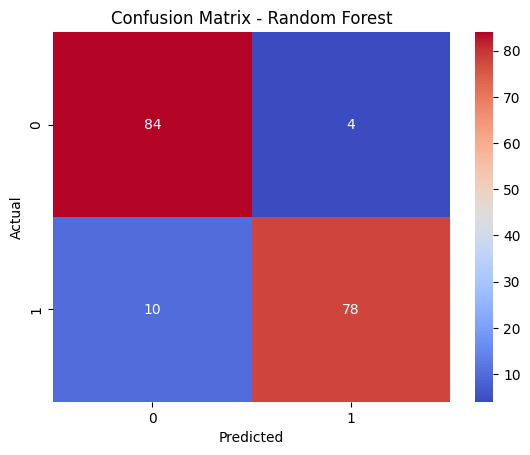

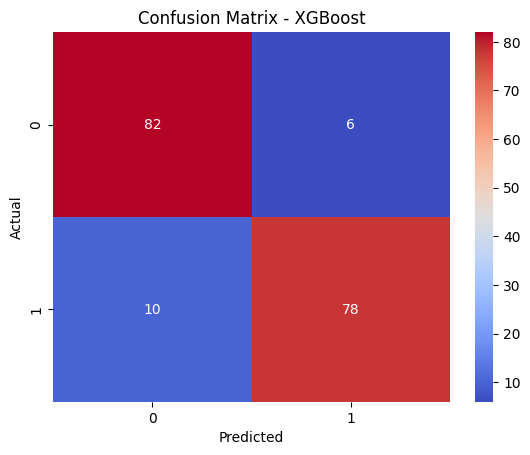

In [138]:

print("Undersampling and Random Forest Model")
print(classification_report(y_test_use, rf_preds))

print("Undersampling and XGBoost Model")
print(classification_report(y_test_use, xgb_preds))

sns.heatmap(confusion_matrix(y_test_use, rf_preds), annot=True, fmt='d', cmap='coolwarm')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


sns.heatmap(confusion_matrix(y_test_use, xgb_preds), annot=True, fmt='d', cmap='coolwarm')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Random forest hem dolandırıcı aktarımları tespit etmede hem de normal aktarımları tespit etmede XGBoost 'dan daha başarılı olmuştur.

In [139]:
test_loss, test_acc, test_f1_score= nn_model_use.evaluate(X_test_use, y_test_use)

y_pred_prob = nn_model_use.predict(X_test_use)

y_pred = (y_pred_prob > 0.5).astype(int)

y_true = np.array(y_test_use).astype(int)

f1 = f1_score(y_true, y_pred)

print(f"Test Loss : {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"F1 Score: {f1:.4f}")

6/6 [==============================] - 0s 1000us/step
Test Loss : 0.2050
Test Accuracy: 0.9432
F1 Score: 0.9419


Bu üç modelin sonucu karşılaştırıldığında en iyi sonucu nöral ağın verdiği görülmektedir. Ardından random forest ve XGBoost gelmektedir. Nöral ağ 0.94 F1 skoruna sahipken random forest 0.02, XGBoost ise 0.91 F1 skoruna sahip olmuştur. 

Sonuç olarak nöral ağ kullanılması gerektiğini düşünüyorum.